## Modelling part 1: Reproducing the paper results

Expected results:
- SST (Sea Surface Temperature) (increase) influences hard corals negatively
- Photosynthetic active raditation (PAR) as well
- Wind speed helps cool down 
- UV radiance increase temperature
- Deep water helps coral from temperature 


#### Update 17.05
Made a mistake when deriving the meaningful set, corrected now

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd

import data_processing_helper as dp
import practical_functions as pf

import warnings
warnings.filterwarnings("ignore")

In [10]:
df_data = pd.read_csv("../Data/merged_30_04.csv")
df_extended = pd.read_csv("../Data/merged_5_05_extended.csv")
df_data.drop(columns = "id", inplace = True)

In [11]:
df_IND_diff = pd.read_csv("../Data/Intermediate_csv/diff_IND.csv")
df_AUS_diff = pd.read_csv("../Data/Intermediate_csv/diff_AUS.csv")
df_extended["diff_hard_AUS"] = df_AUS_diff["diff_hard"]

df_extended## Treating the extended file 

Steps: 
- bound the variable to end with its corresponding date
- 


In [12]:
def bound_dates(df_extended, list_dates):
    df_concat = []
    df_wind = []
    df_rad = []
    df_rad_clear = []
    df_DHW = []
    df_SST = []
    end_col_wind = df_extended.columns.get_loc([col for col in df_extended.columns if "wind_" in col][-1]) + 1
    end_col_rad = df_extended.columns.get_loc([col for col in df_extended.columns if "rad_solar_2018-12" in col][0]) +1
    end_col_clear_rad = df_extended.columns.get_loc([col for col in df_extended.columns if "clear_rad_solar_" in col][-1]) +1
    end_col_DHW = df_extended.columns.get_loc([col for col in df_extended.columns if "DHW_" in col][-1])+ 1
    end_col_SST = df_extended.columns.get_loc([col for col in df_extended.columns if "SST_" in col][-1]) + 1
    for date in list_dates:
        df_date = df_extended[df_extended["surveydate"] == date]
        lend_date = [col for col in df_extended.columns if date in col]
        
        st_wind = df_extended.columns.get_loc(lend_date[0]) + 1
        st_rad = df_extended.columns.get_loc(lend_date[1]) + 1
        st_clear_rad = df_extended.columns.get_loc(lend_date[2])+1 
        st_DHW = df_extended.columns.get_loc(lend_date[3]) + 1
        st_SST = df_extended.columns.get_loc(lend_date[4]) +1
        
    
        
        df = df_date.iloc[:, np.r_[:st_wind, end_col_wind:st_rad, end_col_rad:st_clear_rad, end_col_clear_rad:st_DHW, end_col_DHW:st_SST]]
        df_wind.append(df_date.iloc[:, np.r_[:st_wind]])
        df_rad.append(df_date.iloc[:, np.r_[end_col_wind:st_rad]])
        df_rad_clear.append(df_date.iloc[:, np.r_[end_col_rad:st_clear_rad]])
        df_DHW.append(df_date.iloc[:, np.r_[end_col_clear_rad:st_DHW]])
        df_SST.append(df_date.iloc[:, np.r_[end_col_DHW:st_SST]])
        
        df_concat.append(df)
        
    df = pd.concat(df_wind).join(pd.concat(df_rad)).join(pd.concat(df_rad_clear)).join(pd.concat(df_DHW)).join(pd.concat(df_SST))
        
    return df
        

        
    

In [13]:
list_dates = df_extended["surveydate"].unique()

In [14]:
# In this dataframe, the end dates for variables is in the start of the survey date (we don't know the future )
df_date_match= bound_dates(df_extended, list_dates)

In [17]:
df_date_match.to_csv("../Data/df_extended_correct_end_dates_17_05.csv", index = False)

In [18]:
df_extended = df_date_match

# Make meaningful variables out of the data

#### Working with wind data
- Take mean/min/max/range two months before, 6 months before, 12 months before, 10 years, 20 years
--> Not very valuable I think due to the resolution :(

Improvement is to use hourly around the time of survey
https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land?tab=overview

In [24]:
def process_meaningful_data(df, name_var, date):
    id_end = df_extended.columns.get_loc([col for col in df_extended.columns if format(f"{name_var}{date}") in col][0])
    df_meaning = []
    
    
    month_before = 2
    
    if (format(f"{name_var}") in df_extended.columns[id_end-month_before]):
        
        df_meaning.append(process_all(df, name_var, month_before, id_end))
    month_before = 6
    if (format(f"{name_var}") in df_extended.columns[id_end-month_before]):
        df_meaning.append(process_all(df, name_var, month_before, id_end))
    month_before = 12
    if (format(f"{name_var}") in df_extended.columns[id_end-month_before]):
        df_meaning.append(process_all(df, name_var, month_before, id_end))
    month_before = 12*10
    if (format(f"{name_var}") in df_extended.columns[id_end-month_before]):
        df_meaning.append(process_all(df, name_var, month_before, id_end))

    
    month_before = 12*20
    
    if (format(f"{name_var}{date}") in df_extended.columns[id_end-month_before]):
        df_meaning.append(process_all(df, name_var, month_before, id_end))
    
    if (not df_meaning):
        # empty concatenation
        return 
    
    return pd.concat(df_meaning, axis = 1)

    

def process_all(df, name_var, month_before, id_end):
    df[format(f"{name_var}{month_before}_monthly_avg")] = monthly_average(df, month_before, id_end)
    df[format(f"{name_var}{month_before}_monthly_min")] = min_monthly(df, month_before, id_end)
    df[format(f"{name_var}{month_before}_monthly_max")] = max_monthly(df, month_before, id_end)
    df[format(f"{name_var}{month_before}_monthly_range")] = range_monthly(df, month_before, id_end) 
    merge_ = pd.concat([df[format(f"{name_var}{month_before}_monthly_avg")],df[format(f"{name_var}{month_before}_monthly_min")], df[format(f"{name_var}{month_before}_monthly_max")], df[format(f"{name_var}{month_before}_monthly_range")]], axis = 1)
    
    return merge_
    
def monthly_average(df, number_of_months, id_end):
    # does not include the month of interest
    return df[df.columns[id_end-number_of_months:id_end]].mean(axis = 1)
def min_monthly(df, number_of_months, id_end):
    return df[df.columns[id_end-number_of_months:id_end]].min(axis = 1)
def max_monthly(df, number_of_months, id_end):
    return df[df.columns[id_end-number_of_months:id_end]].max(axis = 1)
def range_monthly(df, number_of_months, id_end):
    min_ = min_monthly(df, number_of_months, id_end)
    max_ = max_monthly(df, number_of_months, id_end)
    return max_ - min_

def combine_processing_dates(df, name_var, list_dates):
    
    list_df = []
    
    for date in list_dates:
        df_date = df[df["surveydate"] == date]
       
        list_df.append(process_meaningful_data(df_date, name_var, date))
        
    
    
    return pd.concat(list_df)
        
        
def process_all_variables(df, list_dates, list_var):        
    
    list_all_df = []
    
    for name_var in list_var:
        list_all_df.append(combine_processing_dates(df, name_var, list_dates))
        
        
    
    return pd.concat(list_all_df, axis = 1)
    
    
    

In [25]:
names_variables = ["wind_", "solar_", "clear_rad_solar_", "SST_", "DHW_"]


In [26]:

Combine_useful_variables = process_all_variables(df_extended, list_dates, names_variables)

In [28]:
# starts with wind, ends with SST 
start_remove = df_extended.columns.get_loc([col for col in df_extended.columns if "wind_" in col][1])
end_remove = df_extended.columns.get_loc([col for col in df_extended.columns if "SST_" in col][-1]) + 1

In [29]:
df_extended.drop(columns = df_extended.columns[start_remove:end_remove],inplace = True)

In [30]:
df_extended = df_extended.join(Combine_useful_variables)

In [32]:
df_extended.to_csv("../Data/df_all_17_05.csv", index = False)

In [33]:
df_extended = pd.read_csv("../Data/df_all_17_05.csv")
dp.geo_loads(df_extended)
df_extended = pf.make_geo_frame(df_extended)

In [35]:
# Keep columns related to environment
col_env = ['year','pr_hard_coral', 'lat', 'lon','pr_algae','pr_soft_coral', 'pr_oth_invert', 'pr_other', 'country','geometry', 'wind_speed', 'Chlor', 'solar_rad', 'solar_rad_clear_sky', 'DHW', 'SST', 'par', 'elevation']
col_env_ext = ['year','pr_hard_coral', 'lat', 'lon','pr_algae','pr_soft_coral', 'pr_oth_invert', 'pr_other', 'country','geometry', 'wind_speed', 'Chlor', 'solar_rad', 'solar_rad_clear_sky', 'DHW', 'SST', 'par', 'elevation',
        'wind_2_monthly_avg', 'wind_2_monthly_min',
       'wind_2_monthly_max', 'wind_2_monthly_range', 'wind_6_monthly_avg',
       'wind_6_monthly_min', 'wind_6_monthly_max', 'wind_6_monthly_range',
       'wind_12_monthly_avg', 'wind_12_monthly_min', 'wind_12_monthly_max',
       'wind_12_monthly_range', 'wind_120_monthly_avg', 'wind_120_monthly_min',
       'wind_120_monthly_max', 'wind_120_monthly_range', 'solar_2_monthly_avg',
       'solar_2_monthly_min', 'solar_2_monthly_max', 'solar_2_monthly_range',
       'solar_6_monthly_avg', 'solar_6_monthly_min', 'solar_6_monthly_max',
       'solar_6_monthly_range', 'solar_12_monthly_avg', 'solar_12_monthly_min',
       'solar_12_monthly_max', 'solar_12_monthly_range',
       'clear_rad_solar_2_monthly_avg', 'clear_rad_solar_2_monthly_min',
       'clear_rad_solar_2_monthly_max', 'clear_rad_solar_2_monthly_range',
       'clear_rad_solar_6_monthly_avg', 'clear_rad_solar_6_monthly_min',
       'clear_rad_solar_6_monthly_max', 'clear_rad_solar_6_monthly_range',
       'clear_rad_solar_12_monthly_avg', 'clear_rad_solar_12_monthly_min',
       'clear_rad_solar_12_monthly_max', 'clear_rad_solar_12_monthly_range',
       'SST_2_monthly_avg', 'SST_2_monthly_min', 'SST_2_monthly_max',
       'SST_2_monthly_range', 'SST_6_monthly_avg', 'SST_6_monthly_min',
       'SST_6_monthly_max', 'SST_6_monthly_range', 'SST_12_monthly_avg',
       'SST_12_monthly_min', 'SST_12_monthly_max', 'SST_12_monthly_range',
       'SST_120_monthly_avg', 'SST_120_monthly_min', 'SST_120_monthly_max',
       'SST_120_monthly_range', 'DHW_2_monthly_avg', 'DHW_2_monthly_min',
       'DHW_2_monthly_max', 'DHW_2_monthly_range', 'DHW_6_monthly_avg',
       'DHW_6_monthly_min', 'DHW_6_monthly_max', 'DHW_6_monthly_range',
       'DHW_12_monthly_avg', 'DHW_12_monthly_min', 'DHW_12_monthly_max',
       'DHW_12_monthly_range', 'DHW_120_monthly_avg', 'DHW_120_monthly_min',
       'DHW_120_monthly_max', 'DHW_120_monthly_range']
df_data_env = df_extended[col_env]
df_data_env_ext= df_extended[col_env_ext]

### Distribution plots for numerical values depending on country

Text(0.5, 0.98, 'Distribution of environmental features by country')

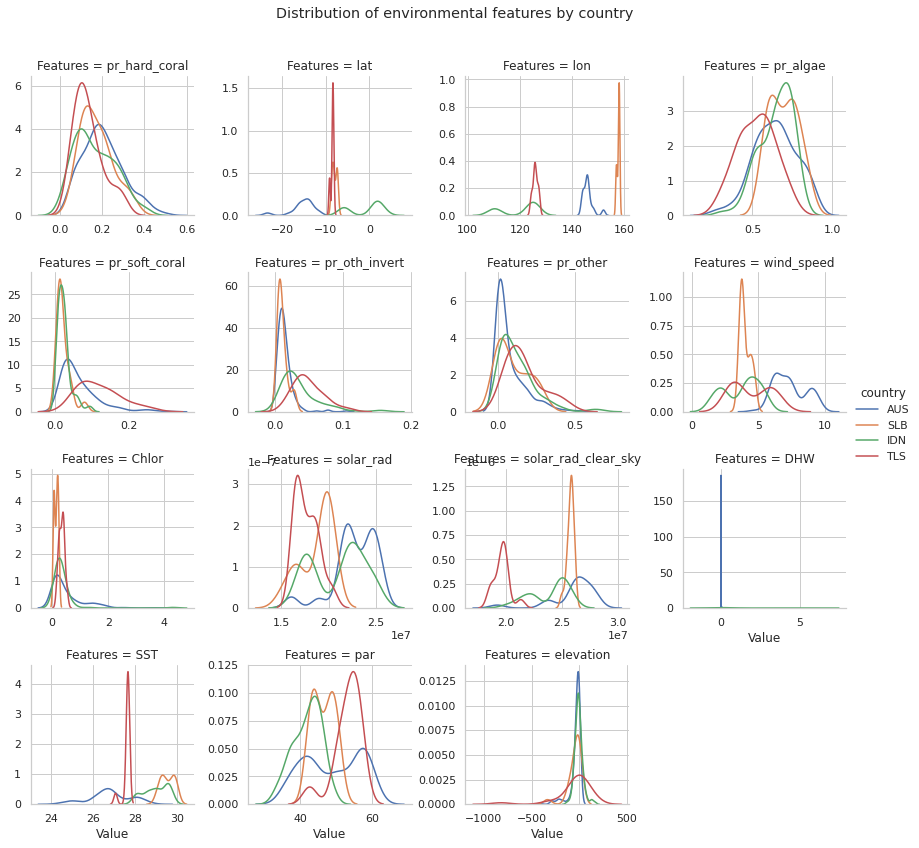

In [36]:
numeric_features= df_data_env.drop(columns = ['country', 'geometry','year'])
numeric_features = numeric_features.stack().reset_index().rename(columns = {"level_1":"Features",0:"Value"})
df_country =  pd.DataFrame(df_data_env["country"])
merged_num = pd.merge(df_country, numeric_features, left_index=True, right_on='level_0')
g = sns.FacetGrid(data =merged_num, col="Features",  hue = "country",col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, "Value",  hist = False)
g.add_legend()
plt.subplots_adjust(top=0.9)
plt.suptitle("Distribution of environmental features by country")

Text(0.5, 0.98, 'Distribution of all features by Year')

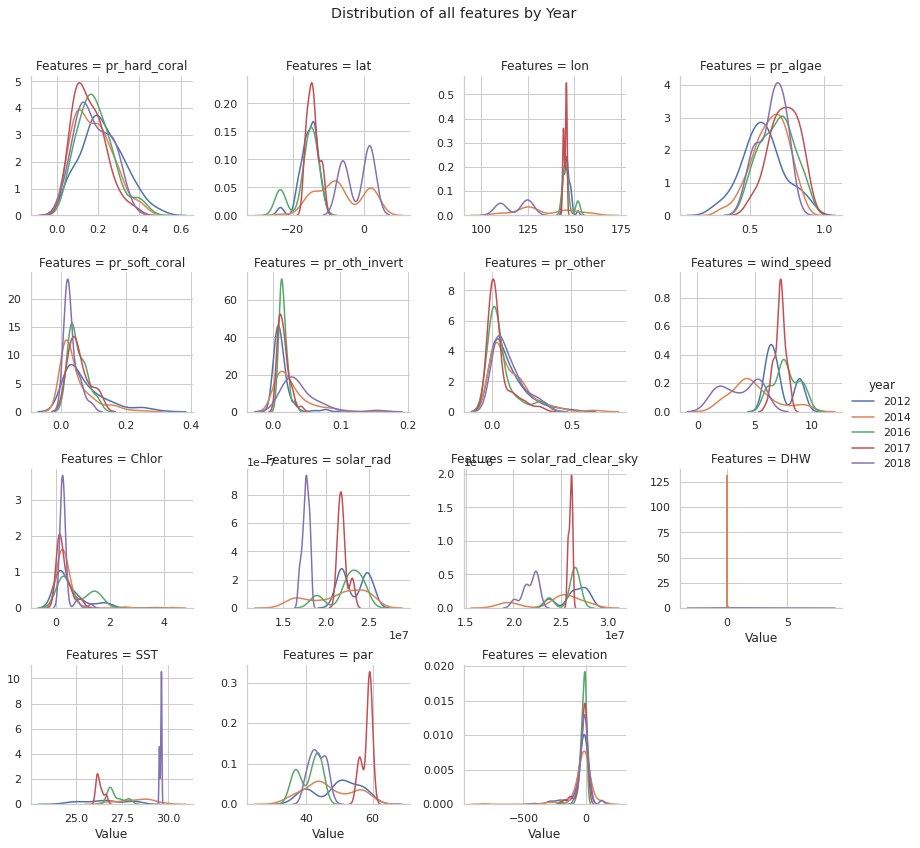

In [37]:
numeric_features= df_data_env.drop(columns = ['year','country', 'geometry'])
numeric_features = numeric_features.stack().reset_index().rename(columns = {"level_1":"Features",0:"Value"})
df_year=  pd.DataFrame(df_data["year"])
merged_num = pd.merge(df_year, numeric_features, left_index=True, right_on='level_0')
g = sns.FacetGrid(data =merged_num, col="Features",  hue = "year",col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, "Value", hist = False)
g.add_legend()
plt.subplots_adjust(top=0.9)
plt.suptitle("Distribution of all features by Year")

df_data_env### Correlation Matrix


In [38]:
df_keep_env = []
df_keep_env_ext = []
df_keep_anth = []

In [39]:

def keep_interesting_corr(corr, df_keep, string):
    return df_keep.append(corr["pr_hard_coral"][1:].to_frame(string))


Text(0.5, 1.0, 'Correlation map for all data')

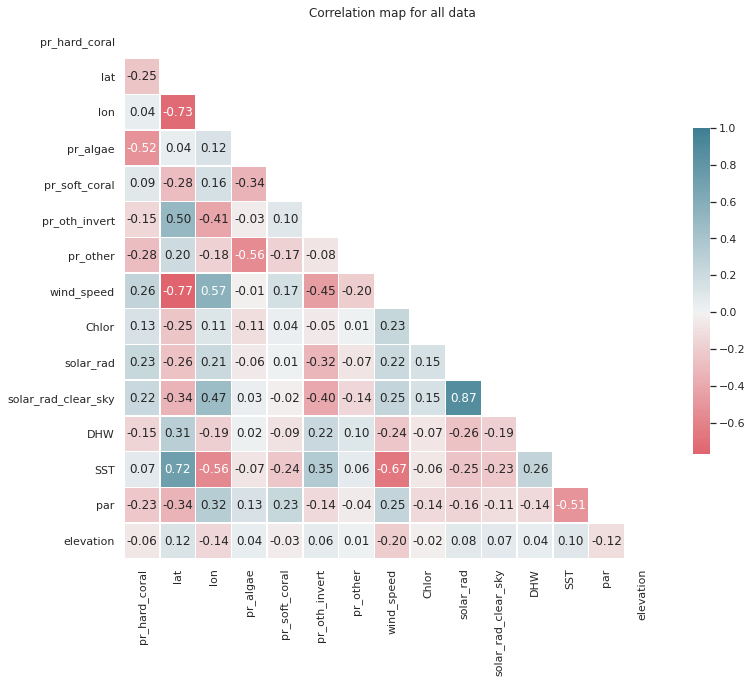

In [40]:
f, ax = plt.subplots(figsize=(12, 12))
corr = df_data_env.drop(columns = ['year','country', 'geometry']).corr()
keep_interesting_corr(corr,df_keep_env, "All data (416)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
# plt.subplots_adjust(top=0.99)
plt.title("Correlation map for all data")

## Separated by year

In [41]:
df_data_env12 = df_data_env[df_data_env["year"] == 2012]
df_data_env14 = df_data_env[df_data_env["year"] == 2014]
df_data_env16 = df_data_env[df_data_env["year"] == 2016]
df_data_env17 = df_data_env[df_data_env["year"] == 2017]
df_data_env18 = df_data_env[df_data_env["year"] == 2018]


In [42]:
print(len(df_data_env12))
print(len(df_data_env14))
print(len(df_data_env16))
print(len(df_data_env17))
len(df_data_env18)

118
162
60
35


41

Text(0.5, 1.0, 'Diagonal Correlation HeatMap for 2012 (only AUS)')

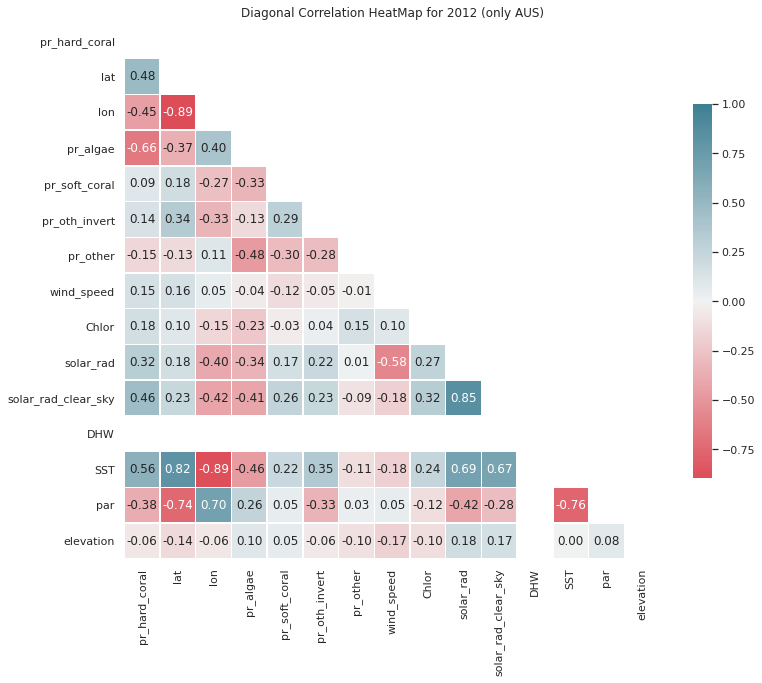

In [43]:
f, ax = plt.subplots(figsize=(12, 12))
corr = df_data_env12.drop(columns = ['year','country', 'geometry']).corr()
keep_interesting_corr(corr,df_keep_env, "2012 (118)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for 2012 (only AUS)")

**Take-aways**
Hard corals have:
- Negative corr with algae (normal)
- Positive corr with solar rad and surface temperature (strange)
- Negative corr with PAR (normal)

Text(0.5, 1.0, 'Diagonal Correlation HeatMap for 2014 (all countries)')

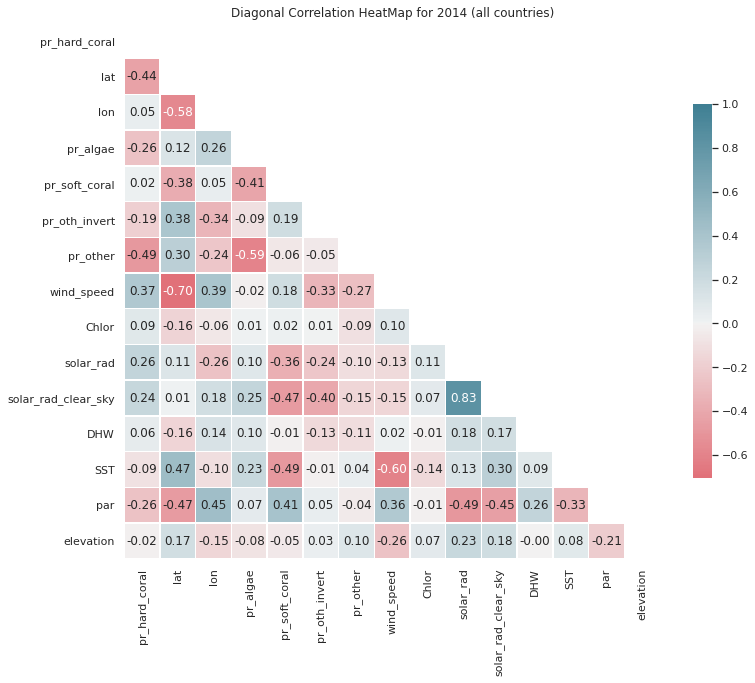

In [44]:
f, ax = plt.subplots(figsize=(12, 12))
corr = df_data_env14.drop(columns = ['year','country', 'geometry']).corr()
keep_interesting_corr(corr,df_keep_env, "2014 (162)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for 2014 (all countries)")

**Take-aways**
- Positive corr with wind speed (normal)


Text(0.5, 1.0, 'Diagonal Correlation HeatMap for 2016 (only AUS)')

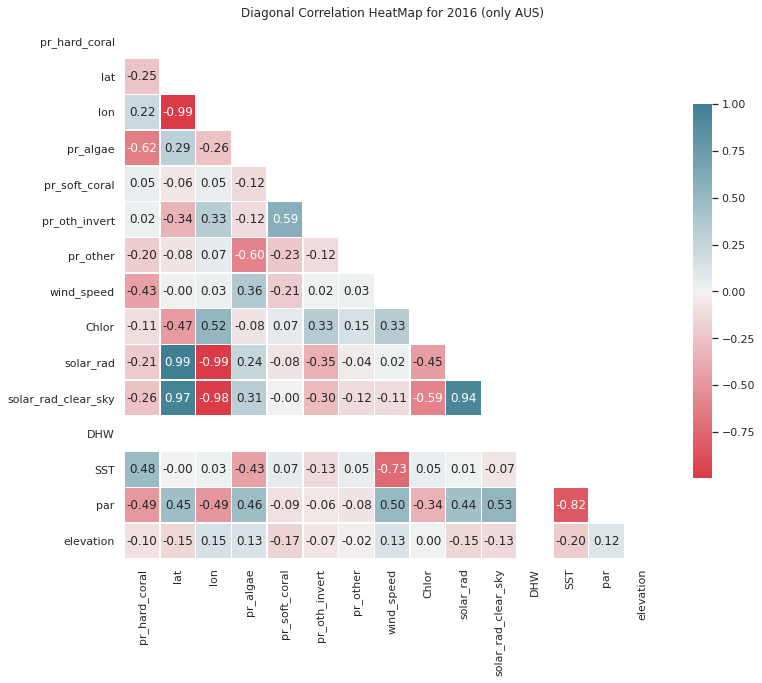

In [45]:
f, ax = plt.subplots(figsize=(12, 12))
corr = df_data_env16.drop(columns = ['year','country', 'geometry']).corr()
keep_interesting_corr(corr,df_keep_env, "2016 (60)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for 2016 (only AUS)")

**Take-aways**
Hard corals have:
- Negative corr with wind speed (strange)
- Positive corr with SST (strange)
- Negative corr with PAR (normal)

Text(0.5, 1.0, 'Diagonal Correlation HeatMap for 2017 (only AUS)')

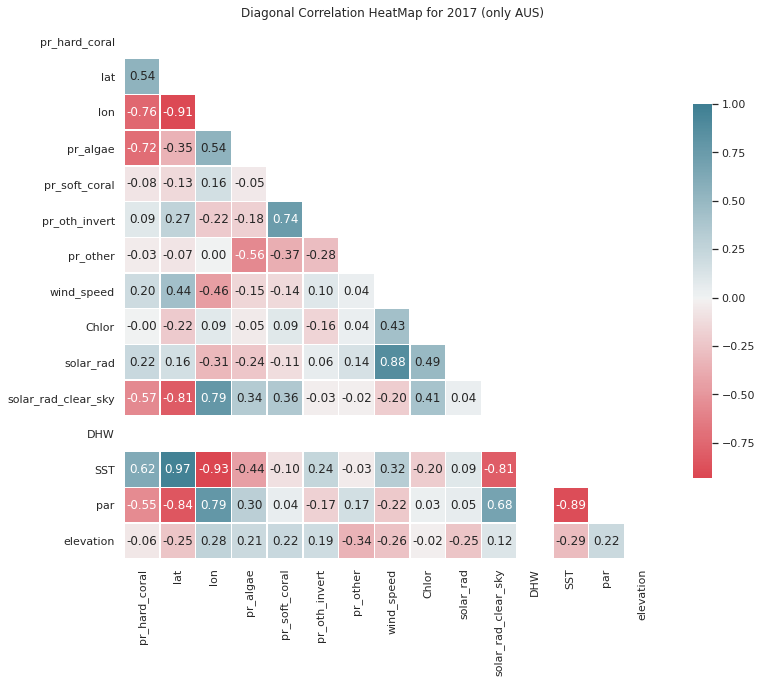

In [46]:
f, ax = plt.subplots(figsize=(12, 12))
corr = df_data_env17.drop(columns = ['year','country', 'geometry']).corr()
keep_interesting_corr(corr,df_keep_env,"2017 (35)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for 2017 (only AUS)")

**Take-aways**
hard corals have:
- negative corr with solar rad (normal)
- positive corr with SST (strange)
- negative corr with PAR (normal)

Text(0.5, 1.0, 'Diagonal Correlation HeatMap for 2018 (only IDN)')

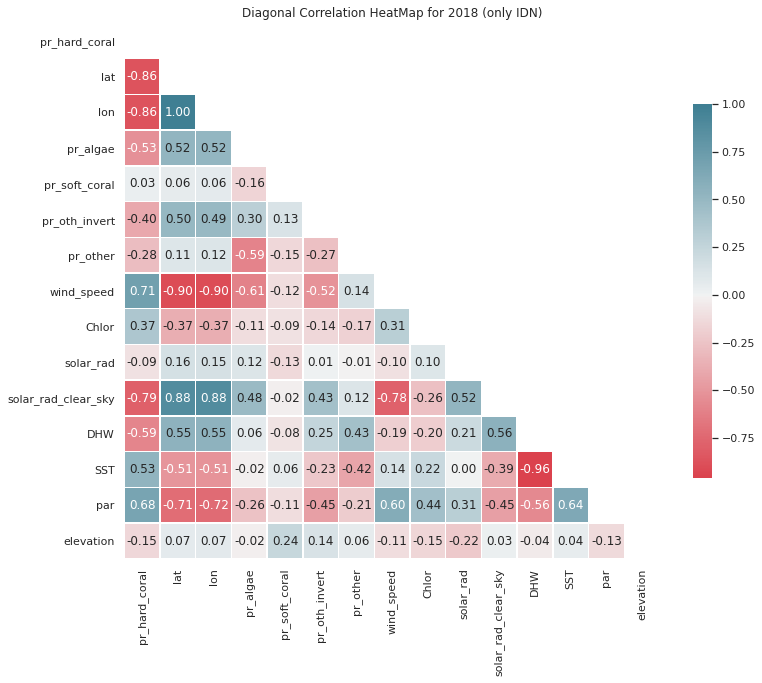

In [47]:
f, ax = plt.subplots(figsize=(12, 12))
corr = df_data_env18.drop(columns = ['year','country', 'geometry']).corr()
keep_interesting_corr(corr,df_keep_env, "2018 (41)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for 2018 (only IDN)")

**Take-aways**
Hard corals:
- positive corr with wind speed (normal)
- negative corr with DHW/Solar (normal)
- Positive corr with SST/PAR (strange)

### Separated by Country

In [48]:
df_data_envAUS = df_data_env[df_data_env["country"] == "AUS"]
df_data_envIDN = df_data_env[df_data_env["country"] == "IDN"]
df_data_envTLS = df_data_env[df_data_env["country"] == "TLS"]
df_data_envSLB = df_data_env[df_data_env["country"] == "SLB"]

In [49]:
print(len(df_data_envAUS))
print(len(df_data_envIDN))
print(len(df_data_envTLS))
print(len(df_data_envSLB))


260
110
26
20


Text(0.5, 1.0, 'Diagonal Correlation HeatMap for Solomon')

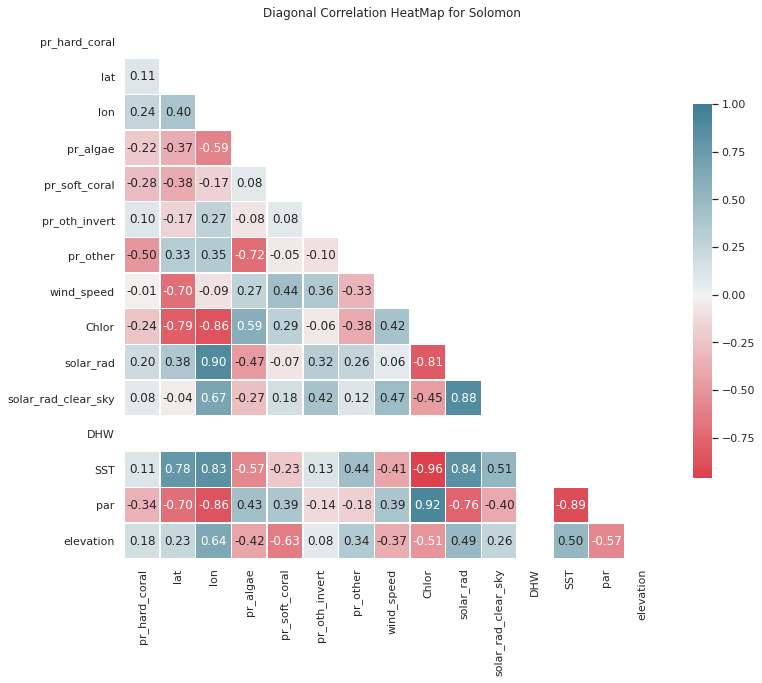

In [50]:
f, ax = plt.subplots(figsize=(12, 12))
corr = df_data_envSLB.drop(columns = ['year','country', 'geometry']).corr()
keep_interesting_corr(corr,df_keep_env, "SLB (20)") 
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for Solomon")

**Take-aways**
Hard corals:
- Negative corr with PAR (normal)


Text(0.5, 1.0, 'Diagonal Correlation HeatMap for Timor Leste')

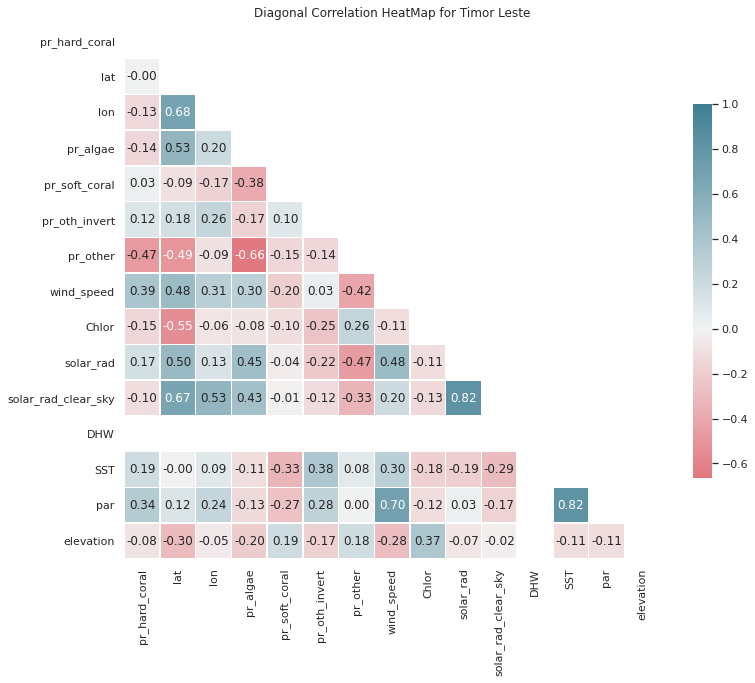

In [51]:
f, ax = plt.subplots(figsize=(12, 12))
corr = df_data_envTLS.drop(columns = ['year','country', 'geometry']).corr()
keep_interesting_corr(corr,df_keep_env, "TLS (26)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for Timor Leste")

**Take-aways**

Hard corals have:
- Positive corr with wind speed (normal)
- Positive corr with PAR (strange)

Text(0.5, 1.0, 'Diagonal Correlation HeatMap for Australia')

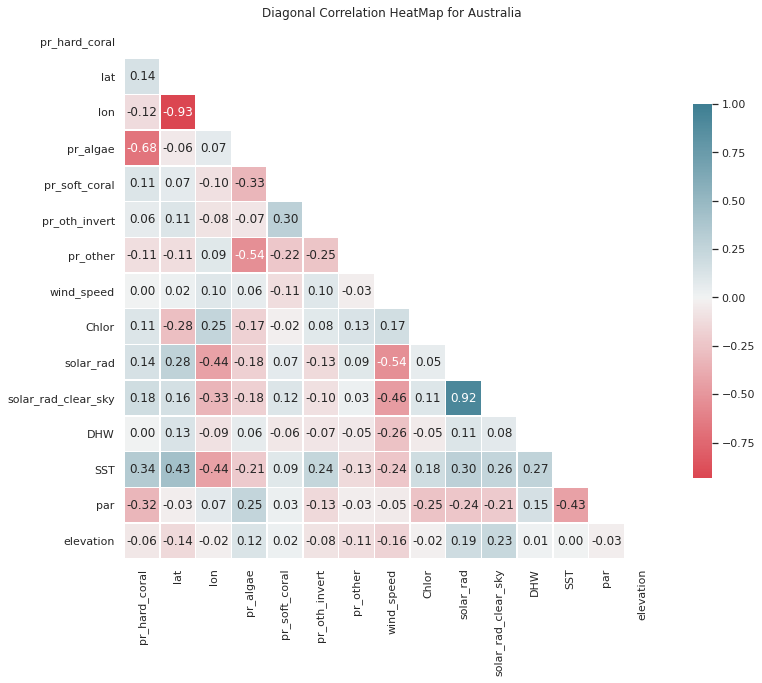

In [52]:
f, ax = plt.subplots(figsize=(12, 12))
corr = df_data_envAUS.drop(columns = ['year','country', 'geometry']).corr()
keep_interesting_corr(corr,df_keep_env, "AUS (260)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for Australia")

**Take-aways**

Hard corals:
- Positive corr with SST (strange)
- Negative corr with PAR (normal)

Text(0.5, 1.0, 'Diagonal Correlation HeatMap for Indonesia')

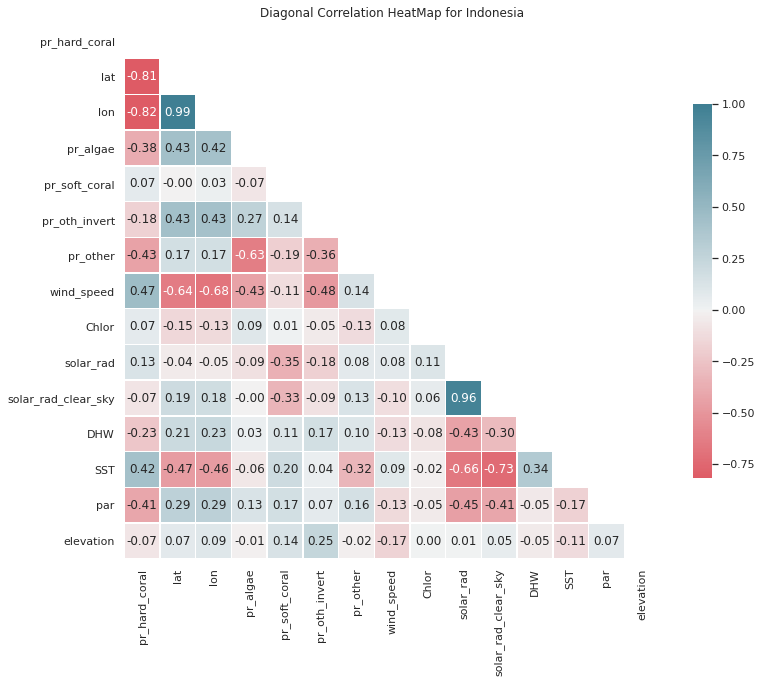

In [53]:
f, ax = plt.subplots(figsize=(12, 12))
corr = df_data_envIDN.drop(columns = ['year','country', 'geometry']).corr()
keep_interesting_corr(corr,df_keep_env, "IDN (110)") 
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for Indonesia")

**Take-aways**

Hard corals have:
- Positive corr with wind speed

In [54]:
frame_corr_env = pd.concat(df_keep_env, axis = 1)

In [55]:
classes = frame_corr_env.columns

In [56]:
strs = ["pr_hard" for x in range(len(frame_corr_env.columns))]

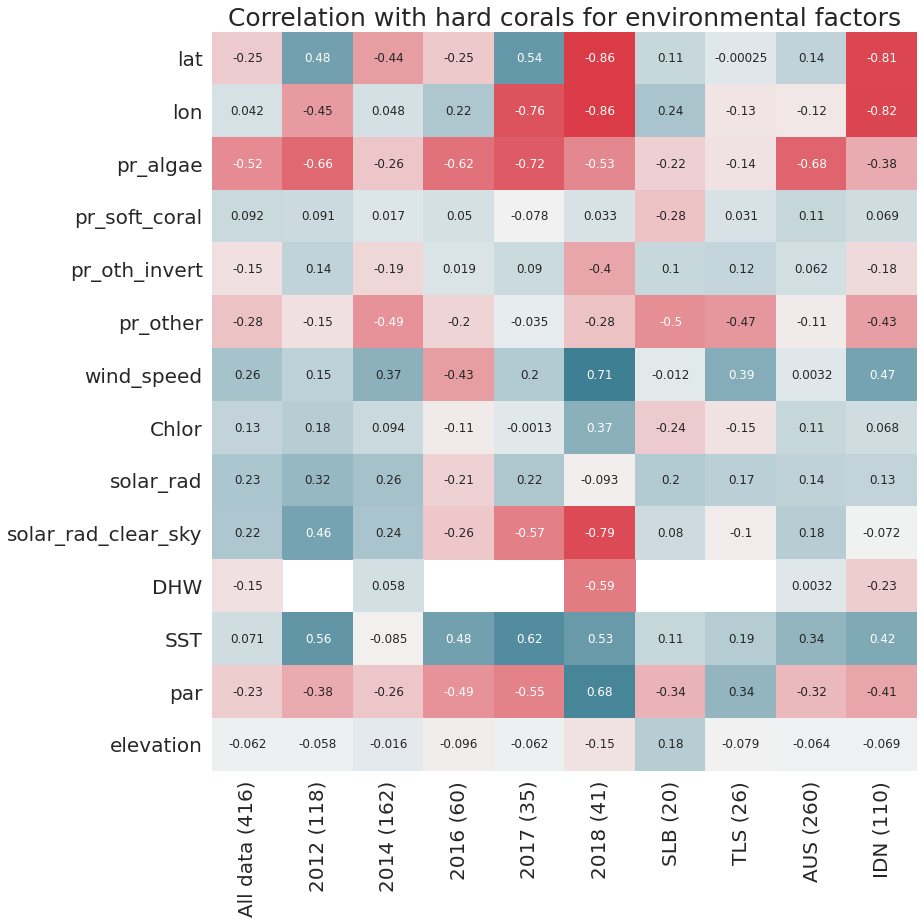

In [57]:
plt.figure(figsize=(13,13))
yticks = frame_corr_env.index
keptticks = yticks[::int(len(yticks)/10)]
yticks = ['' for y in yticks]
yticks[::int(len(yticks)/10)] = keptticks

xticks = frame_corr_env.columns
#xticks = strs
keptticks = xticks[::int(len(xticks)/10)]
xticks = ['' for y in xticks]
xticks[::int(len(xticks)/10)] = keptticks
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.heatmap(frame_corr_env,cmap = cmap, linewidth=0,yticklabels=yticks,xticklabels=xticks,annot=True, cbar = False)

# This sets the yticks "upright" with 0, as opposed to sideways with 90.
plt.yticks(rotation=0, fontsize=20) 
plt.xticks(rotation=90, fontsize=20) 
plt.title("Correlation with hard corals for environmental factors", fontsize=25)
plt.tight_layout()
plt.show()



## Anthropological data

In [58]:
col_anth = ['pr_hard_coral', 'pr_algae','pr_soft_coral', 'pr_oth_invert', 'pr_other', 'country','geometry', 'closest_port', 'year', 'distance_urban',
       'dist_marine_protection', 'Population', 'Population_growth',
        'dist_agr_AUS', 'mine_area_per_call',
       'distance_to_mine_area', 'mine_area_per_cell', 'nigh_avg_2012',
       'nigh_avg_2013', 'nigh_avg_2014', 'nigh_avg_2015', 'nigh_avg_2016',
       'nigh_avg_2017', 'nigh_avg_2018', 'fish_hours_2012', 'fish_hours_2014',
       'fish_hours_2017', 'fish_hours_2016', 'distance_agr_land']
df_data_anth = df_data[col_anth]

### Distribution plots for numerical values depending on country

Text(0.5, 0.98, 'Distribution of anthropological features by country')

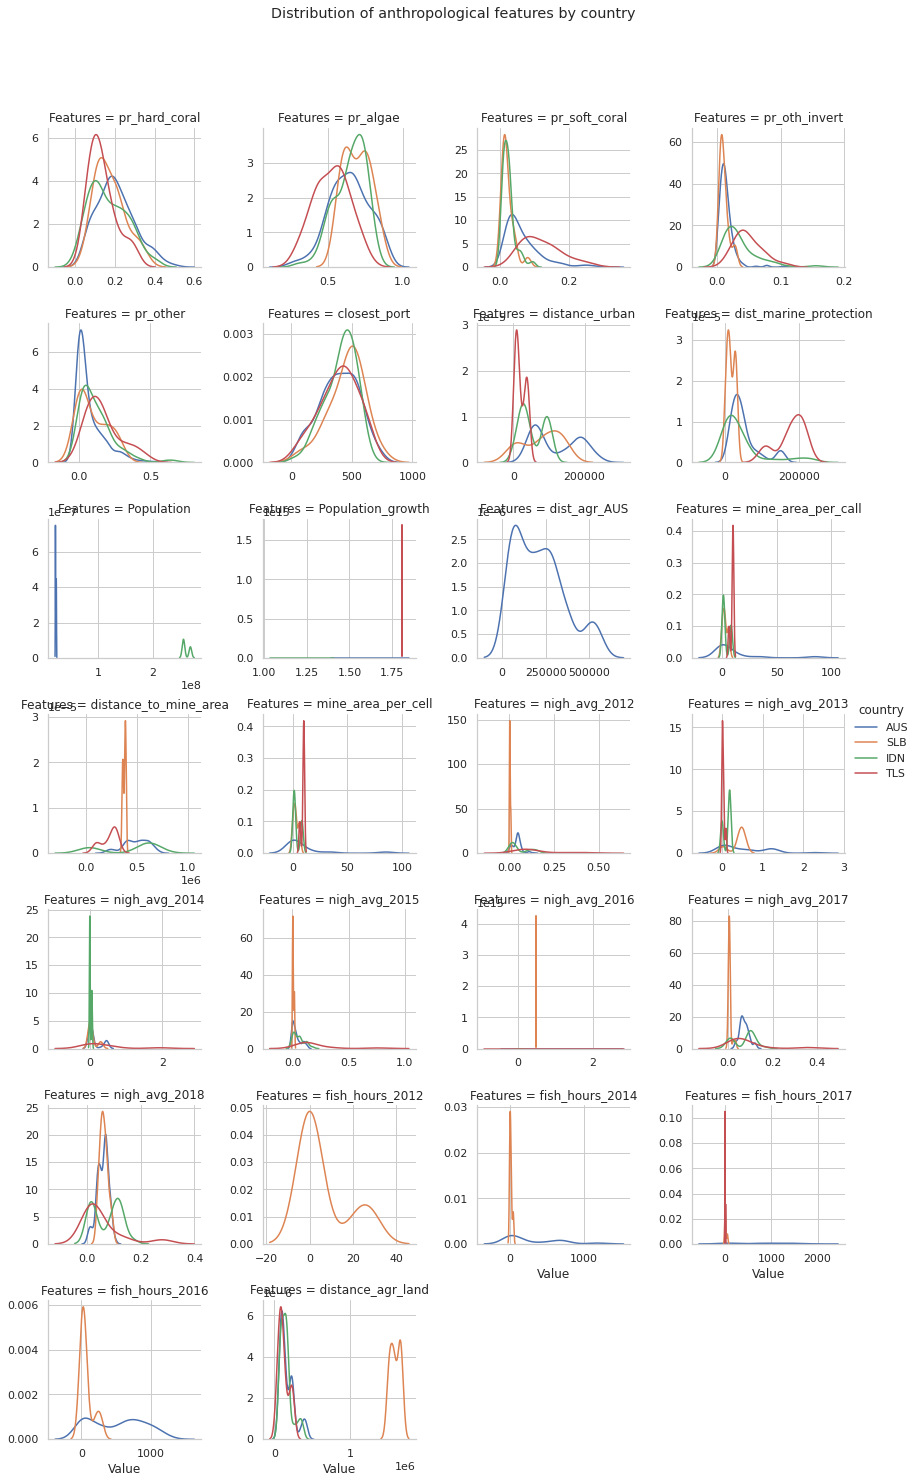

In [59]:
numeric_features= df_data_anth.drop(columns = ['country', 'geometry','year'])
numeric_features = numeric_features.stack().reset_index().rename(columns = {"level_1":"Features",0:"Value"})
df_country =  pd.DataFrame(df_data_anth["country"])
merged_num = pd.merge(df_country, numeric_features, left_index=True, right_on='level_0')
g = sns.FacetGrid(data =merged_num, col="Features",  hue = "country",col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, "Value",  hist = False)
g.add_legend()
plt.subplots_adjust(top=0.9)
plt.suptitle("Distribution of anthropological features by country")

### Correlation Matrix


In [60]:
df_keep_anth = []

Text(0.5, 1.0, 'Correlation map for all data')

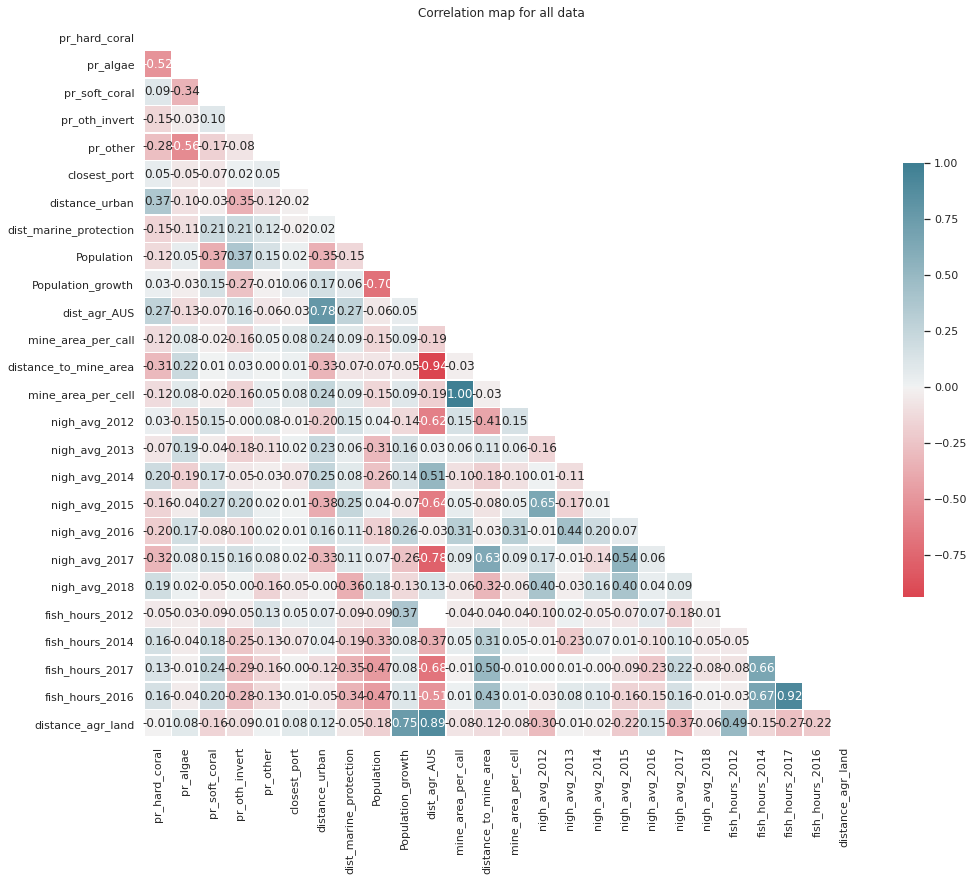

In [61]:
f, ax = plt.subplots(figsize=(16, 16))
corr = df_data_anth.drop(columns = ['year','country', 'geometry']).corr()
keep_interesting_corr(corr, df_keep_anth, "All data (416)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
# plt.subplots_adjust(top=0.99)
plt.title("Correlation map for all data")

## Separated by year

In [62]:
df_data_anth12 = df_data_anth[df_data_anth["year"] == 2012]
df_data_anth14 = df_data_anth[df_data_anth["year"] == 2014]
df_data_anth16 = df_data_anth[df_data_anth["year"] == 2016]
df_data_anth17 = df_data_anth[df_data_anth["year"] == 2017]
df_data_anth18 = df_data_anth[df_data_anth["year"] == 2018]


Text(0.5, 1.0, 'Diagonal Correlation HeatMap for 2012 (only AUS)')

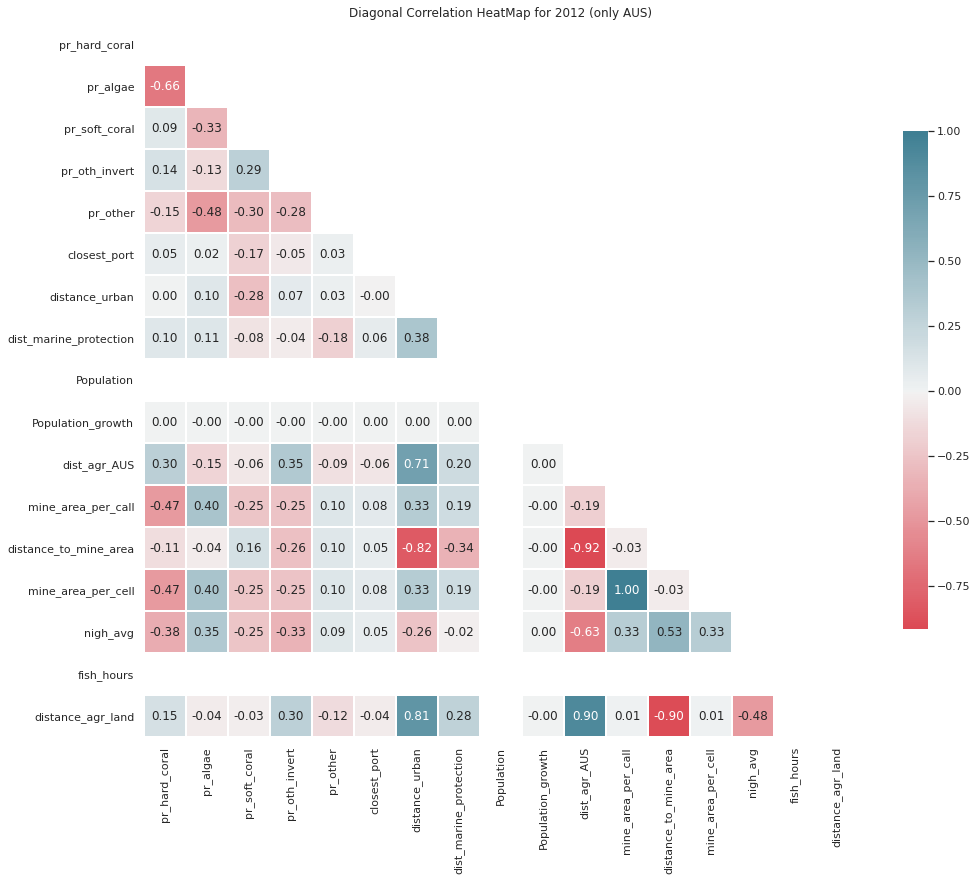

In [63]:
f, ax = plt.subplots(figsize=(16, 16))
corr = df_data_anth12.drop(columns = ['year','country', 'geometry', 'nigh_avg_2013', 'nigh_avg_2014', 'nigh_avg_2015', 'nigh_avg_2016',
       'nigh_avg_2017', 'nigh_avg_2018', 'fish_hours_2014',
       'fish_hours_2017', 'fish_hours_2016']).corr()
corr.rename(index = {"nigh_avg_2012" : "nigh_avg","fish_hours_2012" : "fish_hours"}, columns = {"fish_hours_2012" : "fish_hours","nigh_avg_2012" : "nigh_avg"}, inplace = True)
keep_interesting_corr(corr, df_keep_anth, "2012 (118)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for 2012 (only AUS)")

**Take-aways**
Hard corals have:
- Negative corr with algae (normal)
- Positive corr with solar rad and surface temperature (strange)
- Negative corr with PAR (normal)

Text(0.5, 1.0, 'Diagonal Correlation HeatMap for 2014 (all countries)')

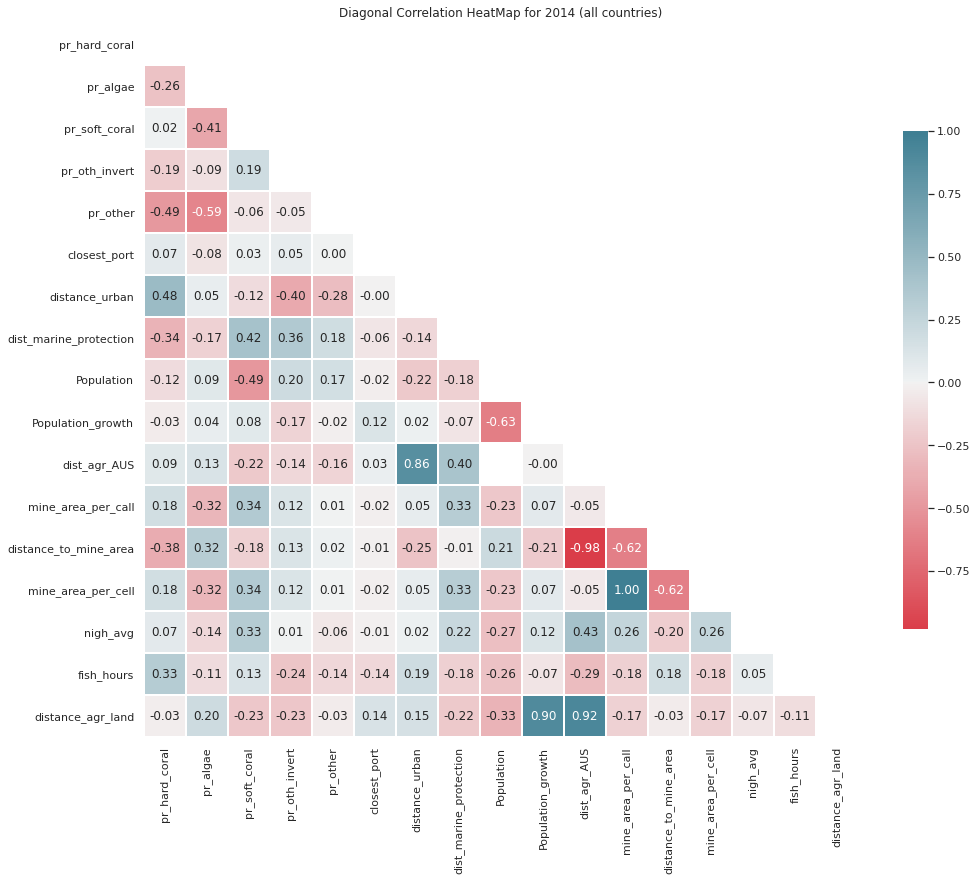

In [64]:
f, ax = plt.subplots(figsize=(16, 16))

corr = df_data_anth14.drop(columns = ['year','country', 'geometry', 'nigh_avg_2013', 'nigh_avg_2012', 'nigh_avg_2015', 'nigh_avg_2016',
       'nigh_avg_2017', 'nigh_avg_2018', 'fish_hours_2012',
       'fish_hours_2017', 'fish_hours_2016']).corr()
corr.rename(index = {"nigh_avg_2014" : "nigh_avg","fish_hours_2014" : "fish_hours"}, columns = {"fish_hours_2014" : "fish_hours","nigh_avg_2014" : "nigh_avg"}, inplace = True)
keep_interesting_corr(corr, df_keep_anth, "2014 (162)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for 2014 (all countries)")

**Take-aways**
- Positive corr with wind speed (normal)


Text(0.5, 1.0, 'Diagonal Correlation HeatMap for 2016 (only AUS)')

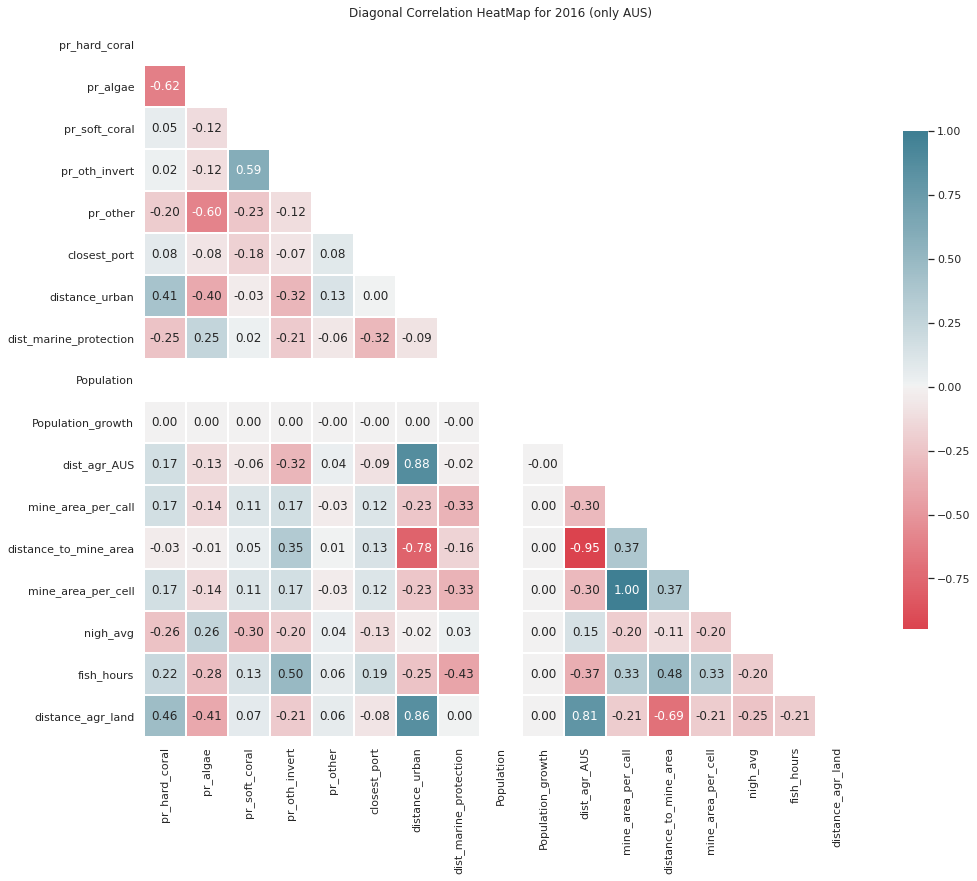

In [65]:
f, ax = plt.subplots(figsize=(16, 16))

corr = df_data_anth16.drop(columns = ['year','country', 'geometry', 'nigh_avg_2013', 'nigh_avg_2014', 'nigh_avg_2015', 'nigh_avg_2012',
       'nigh_avg_2017', 'nigh_avg_2018', 'fish_hours_2014',
       'fish_hours_2017', 'fish_hours_2012']).corr()
corr.rename(index = {"nigh_avg_2016" : "nigh_avg","fish_hours_2016" : "fish_hours"}, columns = {"fish_hours_2016" : "fish_hours","nigh_avg_2016" : "nigh_avg"}, inplace = True)
keep_interesting_corr(corr, df_keep_anth, "2016 (60)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for 2016 (only AUS)")

**Take-aways**
Hard corals have:
- Negative corr with wind speed (strange)
- Positive corr with SST (strange)
- Negative corr with PAR (normal)

Text(0.5, 1.0, 'Diagonal Correlation HeatMap for 2017 (only AUS)')

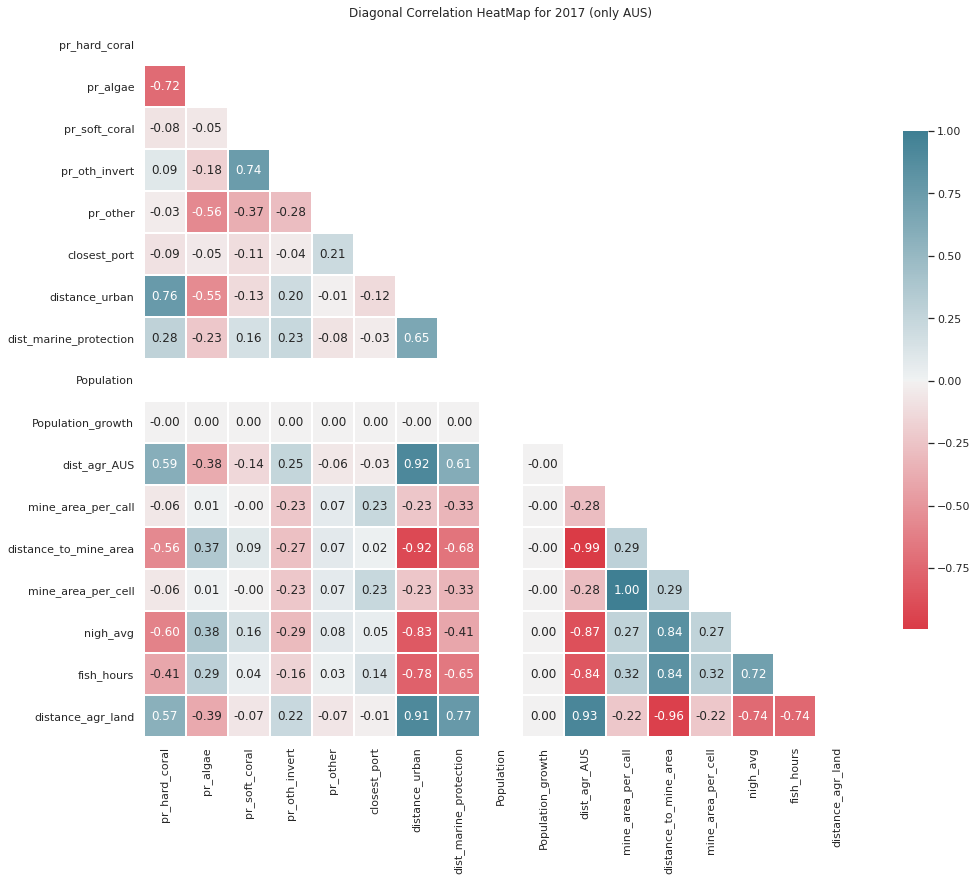

In [66]:
f, ax = plt.subplots(figsize=(16, 16))

corr = df_data_anth17.drop(columns = ['year','country', 'geometry', 'nigh_avg_2013', 'nigh_avg_2014', 'nigh_avg_2015', 'nigh_avg_2016',
       'nigh_avg_2012', 'nigh_avg_2018', 'fish_hours_2014',
       'fish_hours_2012', 'fish_hours_2016']).corr()
corr.rename(index = {"nigh_avg_2017" : "nigh_avg","fish_hours_2017" : "fish_hours"}, columns = {"fish_hours_2017" : "fish_hours","nigh_avg_2017" : "nigh_avg"}, inplace = True)
keep_interesting_corr(corr, df_keep_anth, "2017 (35)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for 2017 (only AUS)")

**Take-aways**
hard corals have:
- negative corr with solar rad (normal)
- positive corr with SST (strange)
- negative corr with PAR (normal)

Text(0.5, 1.0, 'Diagonal Correlation HeatMap for 2018 (only IDN)')

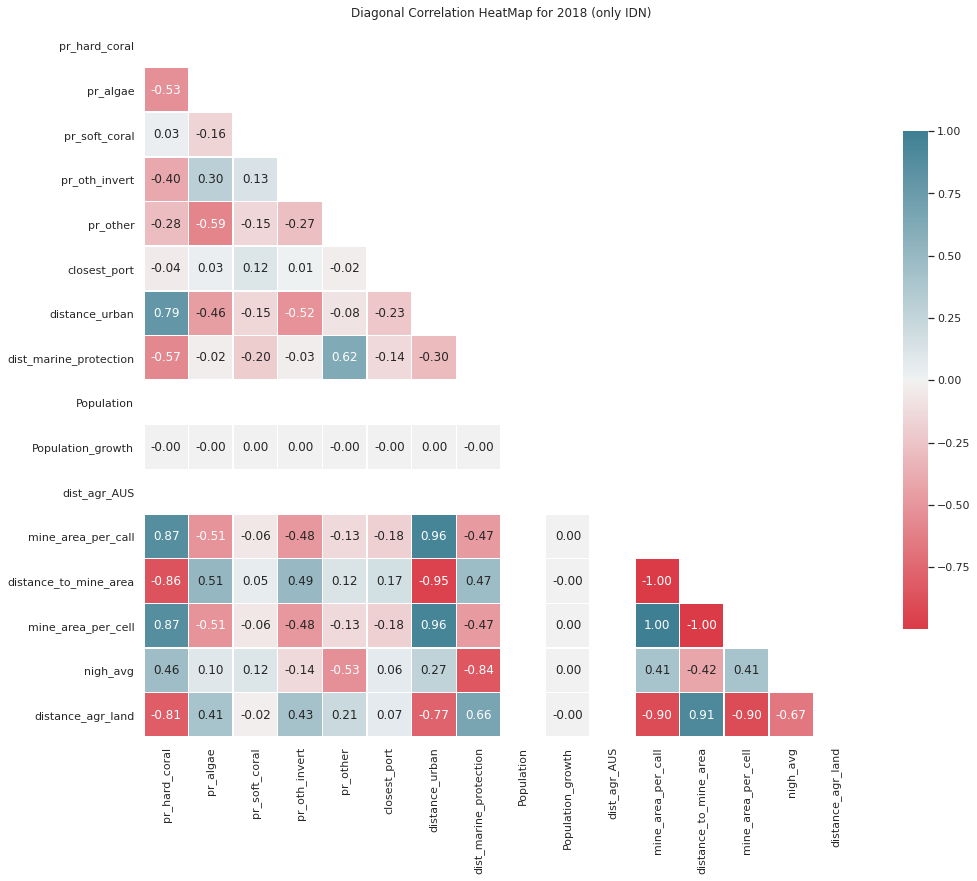

In [67]:
f, ax = plt.subplots(figsize=(16, 16))

corr = df_data_anth18.drop(columns = ['year','country', 'geometry', 'nigh_avg_2013', 'nigh_avg_2014', 'nigh_avg_2015', 'nigh_avg_2016',
       'nigh_avg_2017', 'nigh_avg_2012', 'fish_hours_2014',
       'fish_hours_2017', 'fish_hours_2016','fish_hours_2012']).corr()
corr.rename(index = {"nigh_avg_2018" : "nigh_avg"}, columns = {"nigh_avg_2018" : "nigh_avg"}, inplace = True) 
keep_interesting_corr(corr, df_keep_anth, "2018 (41)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for 2018 (only IDN)")

**Take-aways**
Hard corals:
- positive corr with wind speed (normal)
- negative corr with DHW/Solar (normal)
- Positive corr with SST/PAR (strange)

### Separated by Country

In [68]:
df_data_anthAUS = df_data_anth[df_data_anth["country"] == "AUS"]
df_data_anthIDN = df_data_anth[df_data_anth["country"] == "IDN"]
df_data_anthTLS = df_data_anth[df_data_anth["country"] == "TLS"]
df_data_anhtSLB = df_data_anth[df_data_anth["country"] == "SLB"]


print(len(df_data_anthAUS))
print(len(df_data_anthIDN))
print(len(df_data_anthTLS))
print(len(df_data_anhtSLB))

260
110
26
20


Text(0.5, 1.0, 'Diagonal Correlation HeatMap for Solomon')

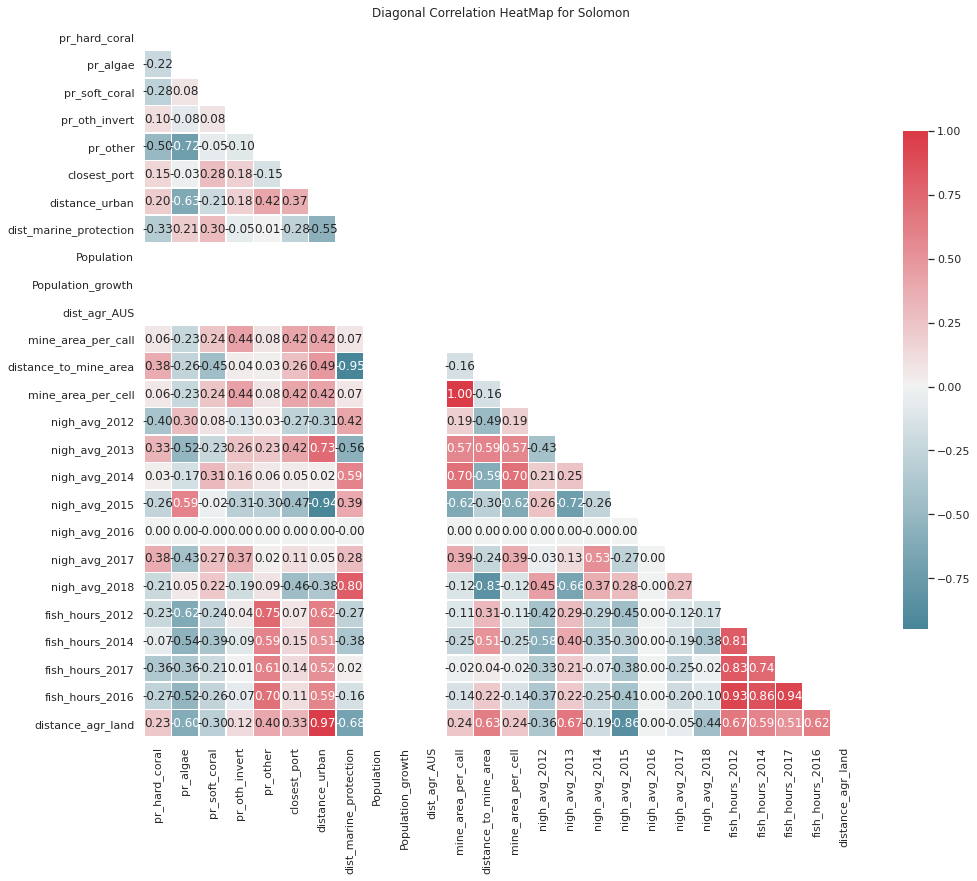

In [69]:
f, ax = plt.subplots(figsize=(16, 16))

corr = df_data_anhtSLB.drop(columns = ['year','country', 'geometry']).corr()
keep_interesting_corr(corr, df_keep_anth, "SLB (20)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(220, 10, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for Solomon")

**Take-aways**
Hard corals:
- Negative corr with PAR (normal)


Text(0.5, 1.0, 'Diagonal Correlation HeatMap for Timor Leste')

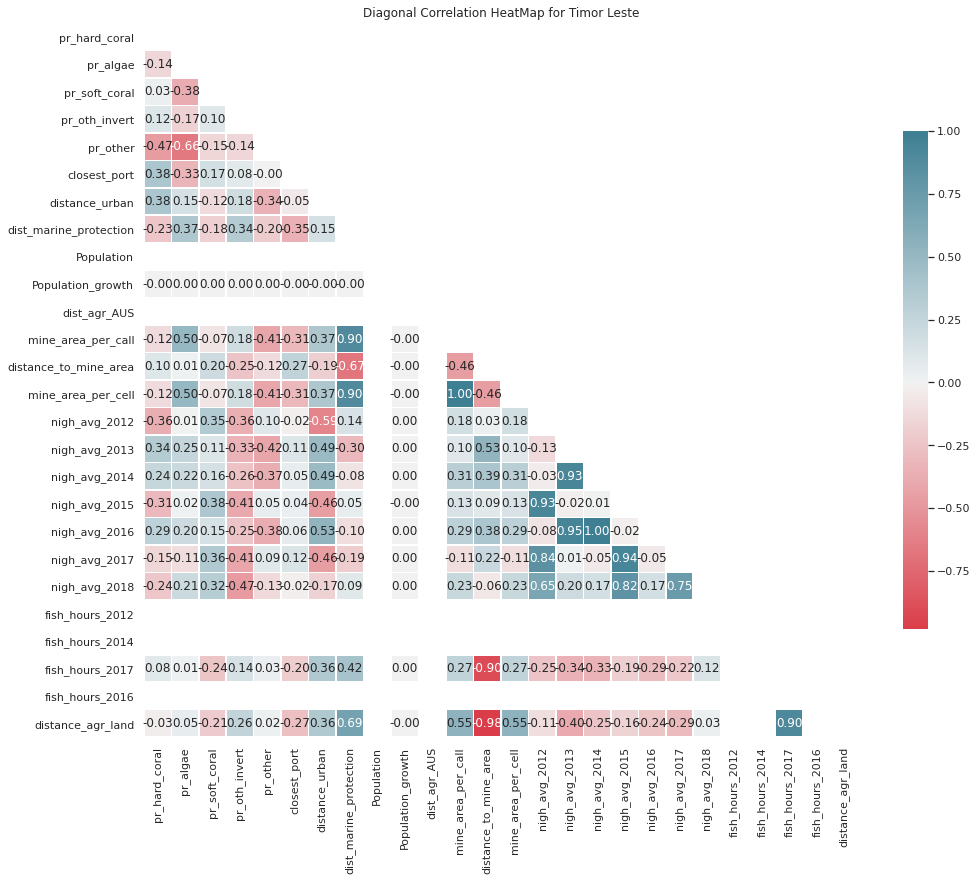

In [70]:
f, ax = plt.subplots(figsize=(16, 16))
corr = df_data_anthTLS.drop(columns = ['year','country', 'geometry']).corr()
keep_interesting_corr(corr, df_keep_anth, "TLS (26)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for Timor Leste")

**Take-aways**

Hard corals have:
- Positive corr with wind speed (normal)
- Positive corr with PAR (strange)

Text(0.5, 1.0, 'Diagonal Correlation HeatMap for Australia')

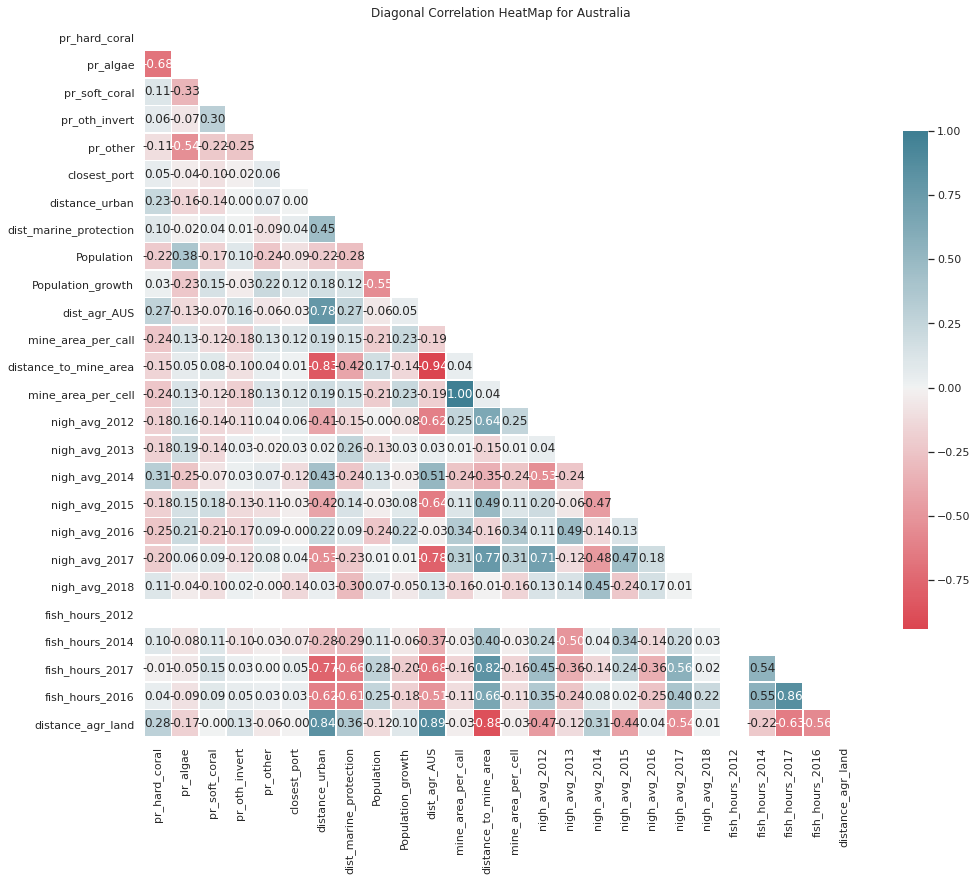

In [71]:
f, ax = plt.subplots(figsize=(16, 16))
corr = df_data_anthAUS.drop(columns = ['year','country', 'geometry']).corr()
keep_interesting_corr(corr, df_keep_anth, "AUS (260)") 
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for Australia")

**Take-aways**

Hard corals:
- Positive corr with SST (strange)
- Negative corr with PAR (normal)

Text(0.5, 1.0, 'Diagonal Correlation HeatMap for Indonesia')

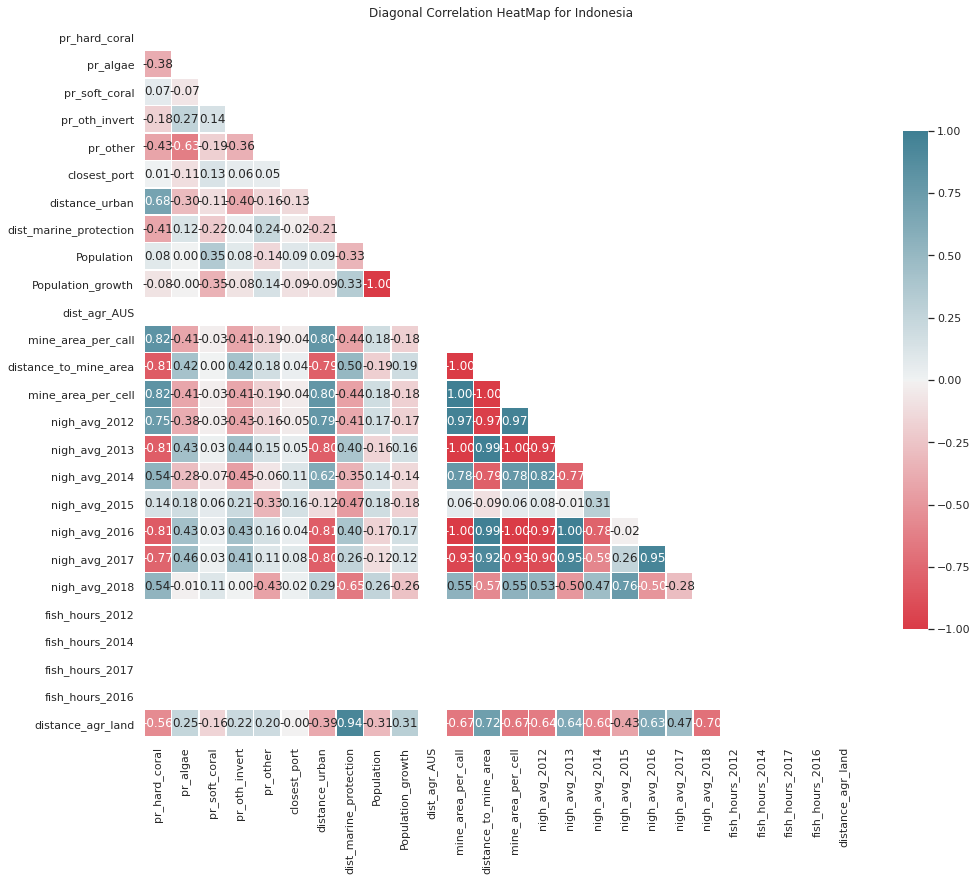

In [72]:
f, ax = plt.subplots(figsize=(16, 16))
corr = df_data_anthIDN.drop(columns = ['year','country', 'geometry']).corr()
keep_interesting_corr(corr, df_keep_anth, "IDN (110)") 
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for Indonesia")

**Take-aways**

Hard corals have:
- Positive corr with wind speed

In [73]:
corr_frame_anth = pd.concat(df_keep_anth, axis = 1)

In [74]:
corr_frame_anth = corr_frame_anth.iloc[4:].drop(index = "mine_area_per_call")

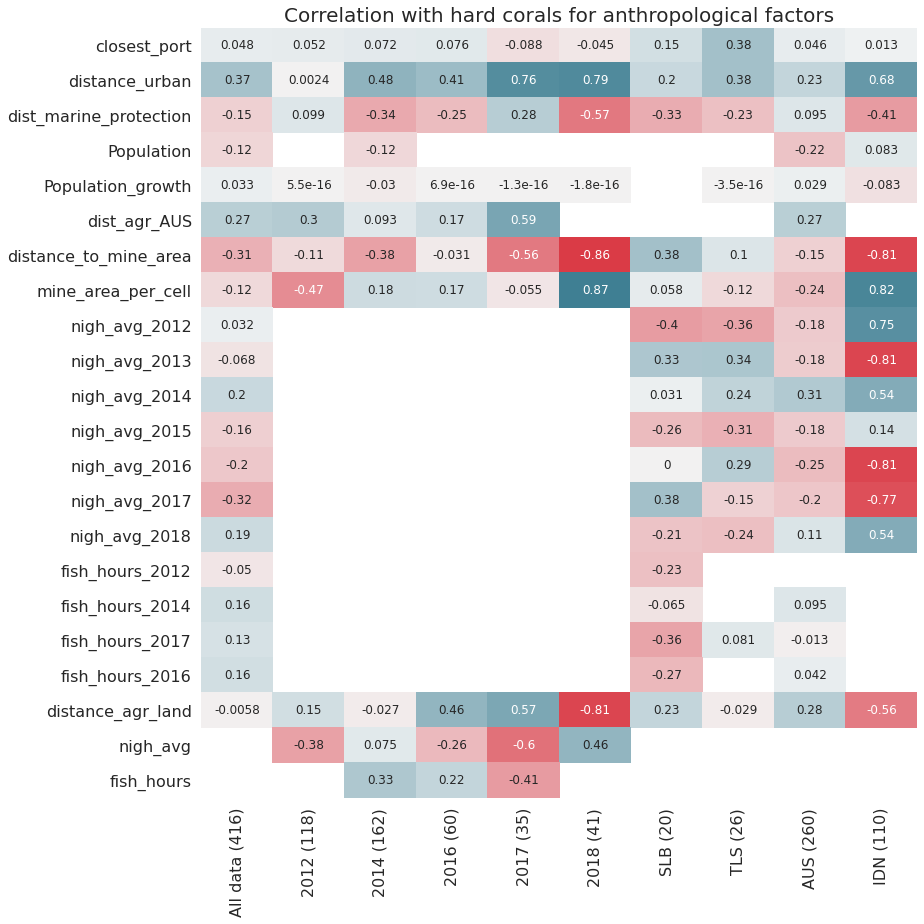

In [75]:
plt.figure(figsize=(13,13))
yticks = corr_frame_anth.index
#keptticks = yticks[::int(len(yticks)/10)]
#yticks = ['' for y in yticks]
#yticks[::int(len(yticks)/10)] = keptticks

xticks = corr_frame_anth.columns
#xticks = strs
keptticks = xticks[::int(len(xticks)/10)]
xticks = ['' for y in xticks]
xticks[::int(len(xticks)/10)] = keptticks
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.heatmap(corr_frame_anth,cmap = cmap, linewidth=0,yticklabels=yticks,xticklabels=xticks,annot=True, cbar = False)

# This sets the yticks "upright" with 0, as opposed to sideways with 90.
plt.yticks(rotation=0, fontsize = 16) 
plt.xticks(rotation=90, fontsize = 16) 
plt.title("Correlation with hard corals for anthropological factors", fontsize = 20)
plt.tight_layout()
plt.show()



### Extended Data

In [76]:
df_keep_env_ext = []

Text(0.5, 1.0, 'Correlation map for all data for anthropological factors')

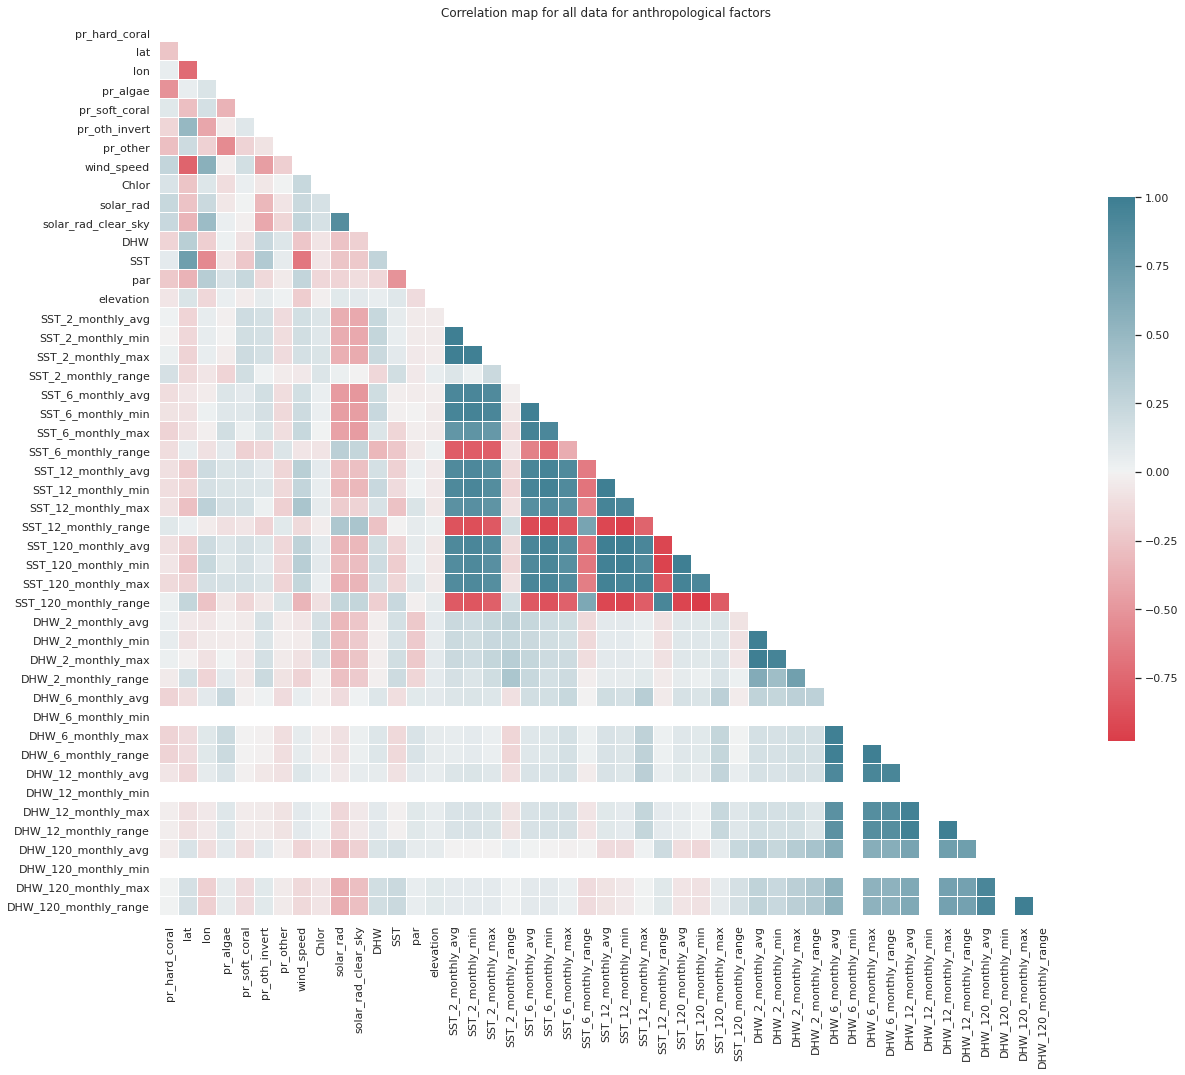

In [77]:
f, ax = plt.subplots(figsize=(20, 20))
corr = df_data_env_ext.drop(columns = ['year','country', 'geometry', 'clear_rad_solar_2_monthly_avg',
       'clear_rad_solar_2_monthly_min', 'clear_rad_solar_2_monthly_max',
       'clear_rad_solar_2_monthly_range', 'clear_rad_solar_6_monthly_avg',
       'clear_rad_solar_6_monthly_min', 'clear_rad_solar_6_monthly_max',
       'clear_rad_solar_6_monthly_range', 'clear_rad_solar_12_monthly_avg',
       'clear_rad_solar_12_monthly_min', 'clear_rad_solar_12_monthly_max',
       'clear_rad_solar_12_monthly_range', 'wind_2_monthly_avg',
       'wind_2_monthly_min', 'wind_2_monthly_max', 'wind_2_monthly_range',
       'wind_6_monthly_avg', 'wind_6_monthly_min', 'wind_6_monthly_max',
       'wind_6_monthly_range', 'wind_12_monthly_avg', 'wind_12_monthly_min',
       'wind_12_monthly_max', 'wind_12_monthly_range', 'wind_120_monthly_avg',
       'wind_120_monthly_min', 'wind_120_monthly_max',
       'wind_120_monthly_range', 'solar_2_monthly_avg', 'solar_2_monthly_min',
       'solar_2_monthly_max', 'solar_2_monthly_range', 'solar_6_monthly_avg',
       'solar_6_monthly_min', 'solar_6_monthly_max', 'solar_6_monthly_range',
       'solar_12_monthly_avg', 'solar_12_monthly_min', 'solar_12_monthly_max',
       'solar_12_monthly_range']).corr()
keep_interesting_corr(corr,df_keep_env_ext, "All data (416)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
# plt.subplots_adjust(top=0.99)
plt.title("Correlation map for all data for anthropological factors")

## Separated by year

In [78]:
df_data_env_ext12 = df_data_env_ext[df_data_env_ext["year"] == 2012]
df_data_env_ext14 = df_data_env_ext[df_data_env_ext["year"] == 2014]
df_data_env_ext16 = df_data_env_ext[df_data_env_ext["year"] == 2016]
df_data_env_ext17 = df_data_env_ext[df_data_env_ext["year"] == 2017]
df_data_env_ext18 = df_data_env_ext[df_data_env_ext["year"] == 2018]


Text(0.5, 1.0, 'Diagonal Correlation HeatMap for 2012 (only AUS)')

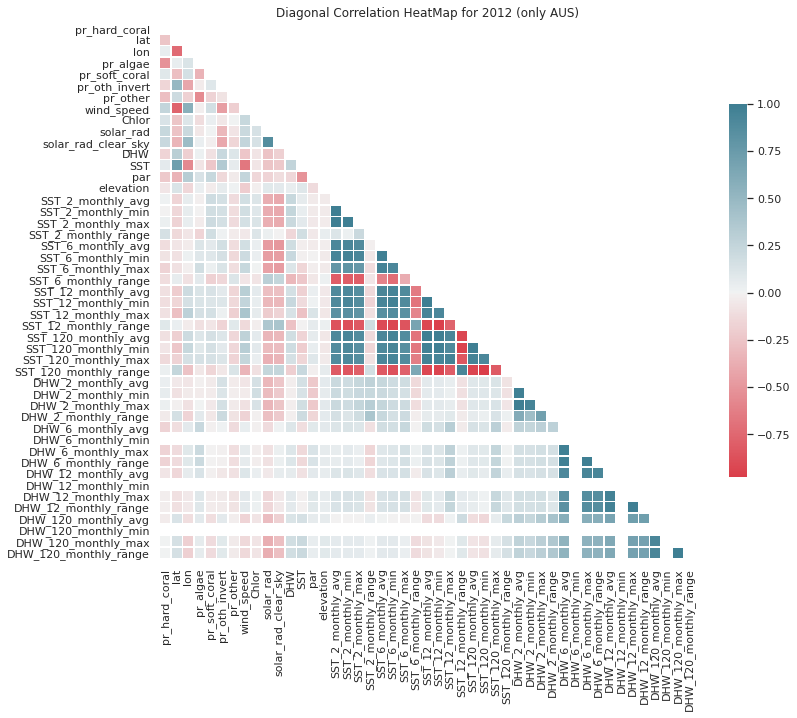

In [79]:
f, ax = plt.subplots(figsize=(12, 12))
corr = df_data_env_ext.drop(columns = ['year','country', 'geometry', 'clear_rad_solar_2_monthly_avg',
       'clear_rad_solar_2_monthly_min', 'clear_rad_solar_2_monthly_max',
       'clear_rad_solar_2_monthly_range', 'clear_rad_solar_6_monthly_avg',
       'clear_rad_solar_6_monthly_min', 'clear_rad_solar_6_monthly_max',
       'clear_rad_solar_6_monthly_range', 'clear_rad_solar_12_monthly_avg',
       'clear_rad_solar_12_monthly_min', 'clear_rad_solar_12_monthly_max',
       'clear_rad_solar_12_monthly_range', 'wind_2_monthly_avg',
       'wind_2_monthly_min', 'wind_2_monthly_max', 'wind_2_monthly_range',
       'wind_6_monthly_avg', 'wind_6_monthly_min', 'wind_6_monthly_max',
       'wind_6_monthly_range', 'wind_12_monthly_avg', 'wind_12_monthly_min',
       'wind_12_monthly_max', 'wind_12_monthly_range', 'wind_120_monthly_avg',
       'wind_120_monthly_min', 'wind_120_monthly_max',
       'wind_120_monthly_range', 'solar_2_monthly_avg', 'solar_2_monthly_min',
       'solar_2_monthly_max', 'solar_2_monthly_range', 'solar_6_monthly_avg',
       'solar_6_monthly_min', 'solar_6_monthly_max', 'solar_6_monthly_range',
       'solar_12_monthly_avg', 'solar_12_monthly_min', 'solar_12_monthly_max',
       'solar_12_monthly_range']).corr()
keep_interesting_corr(corr,df_keep_env_ext, "2012 (118)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for 2012 (only AUS)")

df_data_env14**Take-aways**
Hard corals have:
- Negative corr with algae (normal)
- Positive corr with solar rad and surface temperature (strange)
- Negative corr with PAR (normal)

Text(0.5, 1.0, 'Diagonal Correlation HeatMap for 2014 (all countries)')

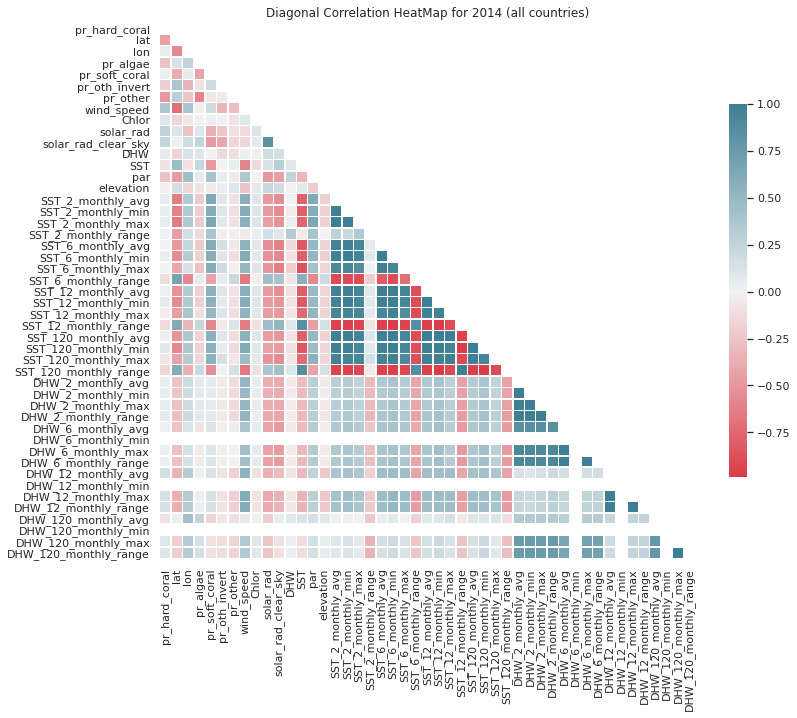

In [80]:
f, ax = plt.subplots(figsize=(12, 12))

corr = df_data_env_ext14.drop(columns = ['year','country', 'geometry', 'clear_rad_solar_2_monthly_avg',
       'clear_rad_solar_2_monthly_min', 'clear_rad_solar_2_monthly_max',
       'clear_rad_solar_2_monthly_range', 'clear_rad_solar_6_monthly_avg',
       'clear_rad_solar_6_monthly_min', 'clear_rad_solar_6_monthly_max',
       'clear_rad_solar_6_monthly_range', 'clear_rad_solar_12_monthly_avg',
       'clear_rad_solar_12_monthly_min', 'clear_rad_solar_12_monthly_max',
       'clear_rad_solar_12_monthly_range', 'wind_2_monthly_avg',
       'wind_2_monthly_min', 'wind_2_monthly_max', 'wind_2_monthly_range',
       'wind_6_monthly_avg', 'wind_6_monthly_min', 'wind_6_monthly_max',
       'wind_6_monthly_range', 'wind_12_monthly_avg', 'wind_12_monthly_min',
       'wind_12_monthly_max', 'wind_12_monthly_range', 'wind_120_monthly_avg',
       'wind_120_monthly_min', 'wind_120_monthly_max',
       'wind_120_monthly_range', 'solar_2_monthly_avg', 'solar_2_monthly_min',
       'solar_2_monthly_max', 'solar_2_monthly_range', 'solar_6_monthly_avg',
       'solar_6_monthly_min', 'solar_6_monthly_max', 'solar_6_monthly_range',
       'solar_12_monthly_avg', 'solar_12_monthly_min', 'solar_12_monthly_max',
       'solar_12_monthly_range']).corr()
keep_interesting_corr(corr,df_keep_env_ext, "2014 (162)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for 2014 (all countries)")

**Take-aways**
- Positive corr with wind speed (normal)


Text(0.5, 1.0, 'Diagonal Correlation HeatMap for 2016 (only AUS)')

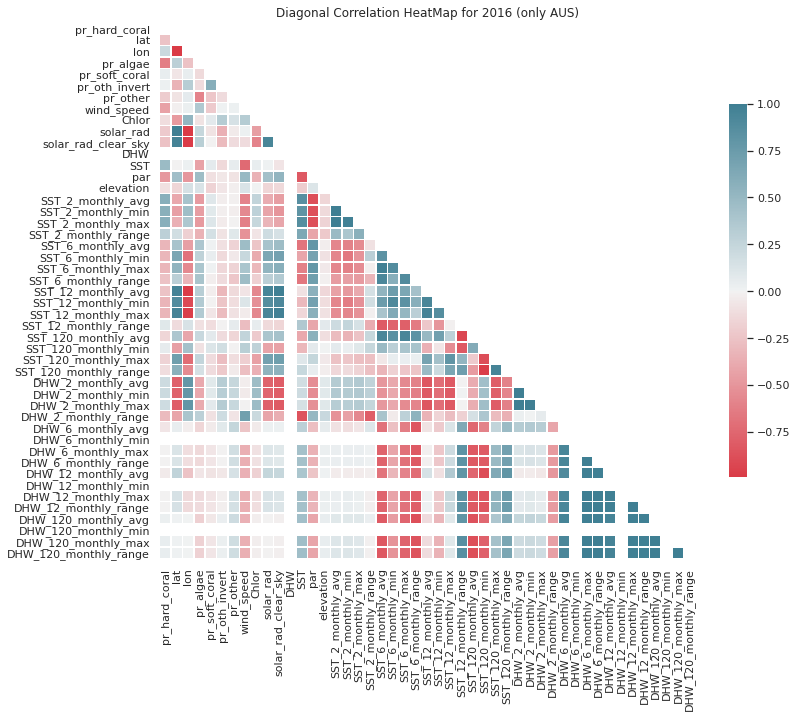

In [81]:
f, ax = plt.subplots(figsize=(12, 12))
corr = df_data_env_ext16.drop(columns = ['year','country', 'geometry', 'clear_rad_solar_2_monthly_avg',
       'clear_rad_solar_2_monthly_min', 'clear_rad_solar_2_monthly_max',
       'clear_rad_solar_2_monthly_range', 'clear_rad_solar_6_monthly_avg',
       'clear_rad_solar_6_monthly_min', 'clear_rad_solar_6_monthly_max',
       'clear_rad_solar_6_monthly_range', 'clear_rad_solar_12_monthly_avg',
       'clear_rad_solar_12_monthly_min', 'clear_rad_solar_12_monthly_max',
       'clear_rad_solar_12_monthly_range', 'wind_2_monthly_avg',
       'wind_2_monthly_min', 'wind_2_monthly_max', 'wind_2_monthly_range',
       'wind_6_monthly_avg', 'wind_6_monthly_min', 'wind_6_monthly_max',
       'wind_6_monthly_range', 'wind_12_monthly_avg', 'wind_12_monthly_min',
       'wind_12_monthly_max', 'wind_12_monthly_range', 'wind_120_monthly_avg',
       'wind_120_monthly_min', 'wind_120_monthly_max',
       'wind_120_monthly_range', 'solar_2_monthly_avg', 'solar_2_monthly_min',
       'solar_2_monthly_max', 'solar_2_monthly_range', 'solar_6_monthly_avg',
       'solar_6_monthly_min', 'solar_6_monthly_max', 'solar_6_monthly_range',
       'solar_12_monthly_avg', 'solar_12_monthly_min', 'solar_12_monthly_max',
       'solar_12_monthly_range']).corr()
keep_interesting_corr(corr,df_keep_env_ext, "2016 (60)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,  fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for 2016 (only AUS)")

**Take-aways**
Hard corals have:
- Negative corr with wind speed (strange)
- Positive corr with SST (strange)
- Negative corr with PAR (normal)

Text(0.5, 1.0, 'Diagonal Correlation HeatMap for 2017 (only AUS)')

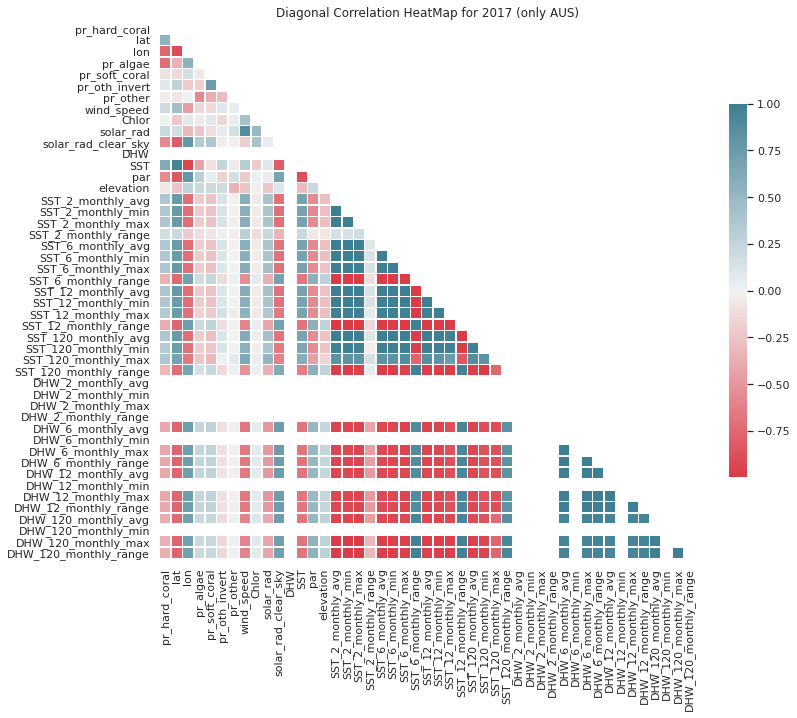

In [82]:
f, ax = plt.subplots(figsize=(12, 12))
corr = df_data_env_ext17.drop(columns = ['year','country', 'geometry', 'clear_rad_solar_2_monthly_avg',
       'clear_rad_solar_2_monthly_min', 'clear_rad_solar_2_monthly_max',
       'clear_rad_solar_2_monthly_range', 'clear_rad_solar_6_monthly_avg',
       'clear_rad_solar_6_monthly_min', 'clear_rad_solar_6_monthly_max',
       'clear_rad_solar_6_monthly_range', 'clear_rad_solar_12_monthly_avg',
       'clear_rad_solar_12_monthly_min', 'clear_rad_solar_12_monthly_max',
       'clear_rad_solar_12_monthly_range', 'wind_2_monthly_avg',
       'wind_2_monthly_min', 'wind_2_monthly_max', 'wind_2_monthly_range',
       'wind_6_monthly_avg', 'wind_6_monthly_min', 'wind_6_monthly_max',
       'wind_6_monthly_range', 'wind_12_monthly_avg', 'wind_12_monthly_min',
       'wind_12_monthly_max', 'wind_12_monthly_range', 'wind_120_monthly_avg',
       'wind_120_monthly_min', 'wind_120_monthly_max',
       'wind_120_monthly_range', 'solar_2_monthly_avg', 'solar_2_monthly_min',
       'solar_2_monthly_max', 'solar_2_monthly_range', 'solar_6_monthly_avg',
       'solar_6_monthly_min', 'solar_6_monthly_max', 'solar_6_monthly_range',
       'solar_12_monthly_avg', 'solar_12_monthly_min', 'solar_12_monthly_max',
       'solar_12_monthly_range']).corr()

keep_interesting_corr(corr,df_keep_env_ext,"2017 (35)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for 2017 (only AUS)")

**Take-aways**
hard corals have:
- negative corr with solar rad (normal)
- positive corr with SST (strange)
- negative corr with PAR (normal)

Text(0.5, 1.0, 'Diagonal Correlation HeatMap for 2018 (only IDN)')

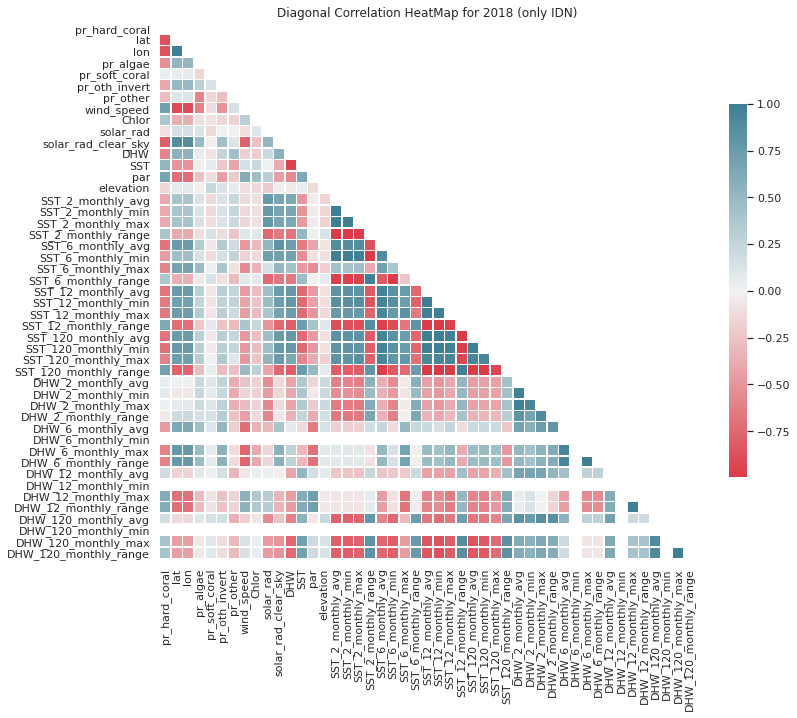

In [83]:
f, ax = plt.subplots(figsize=(12, 12))
corr = df_data_env_ext18.drop(columns = ['year','country', 'geometry', 'clear_rad_solar_2_monthly_avg',
       'clear_rad_solar_2_monthly_min', 'clear_rad_solar_2_monthly_max',
       'clear_rad_solar_2_monthly_range', 'clear_rad_solar_6_monthly_avg',
       'clear_rad_solar_6_monthly_min', 'clear_rad_solar_6_monthly_max',
       'clear_rad_solar_6_monthly_range', 'clear_rad_solar_12_monthly_avg',
       'clear_rad_solar_12_monthly_min', 'clear_rad_solar_12_monthly_max',
       'clear_rad_solar_12_monthly_range', 'wind_2_monthly_avg',
       'wind_2_monthly_min', 'wind_2_monthly_max', 'wind_2_monthly_range',
       'wind_6_monthly_avg', 'wind_6_monthly_min', 'wind_6_monthly_max',
       'wind_6_monthly_range', 'wind_12_monthly_avg', 'wind_12_monthly_min',
       'wind_12_monthly_max', 'wind_12_monthly_range', 'wind_120_monthly_avg',
       'wind_120_monthly_min', 'wind_120_monthly_max',
       'wind_120_monthly_range', 'solar_2_monthly_avg', 'solar_2_monthly_min',
       'solar_2_monthly_max', 'solar_2_monthly_range', 'solar_6_monthly_avg',
       'solar_6_monthly_min', 'solar_6_monthly_max', 'solar_6_monthly_range',
       'solar_12_monthly_avg', 'solar_12_monthly_min', 'solar_12_monthly_max',
       'solar_12_monthly_range']).corr()

keep_interesting_corr(corr,df_keep_env_ext, "2018 (41)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for 2018 (only IDN)")

**Take-aways**
Hard corals:
- positive corr with wind speed (normal)
- negative corr with DHW/Solar (normal)
- Positive corr with SST/PAR (strange)

### Separated by Country

In [84]:
df_data_env_extAUS = df_data_env_ext[df_data_env_ext["country"] == "AUS"]
df_data_env_extIDN = df_data_env_ext[df_data_env_ext["country"] == "IDN"]
df_data_env_extTLS = df_data_env_ext[df_data_env_ext["country"] == "TLS"]
df_data_env_extSLB = df_data_env_ext[df_data_env_ext["country"] == "SLB"]

Text(0.5, 1.0, 'Diagonal Correlation HeatMap for Solomon')

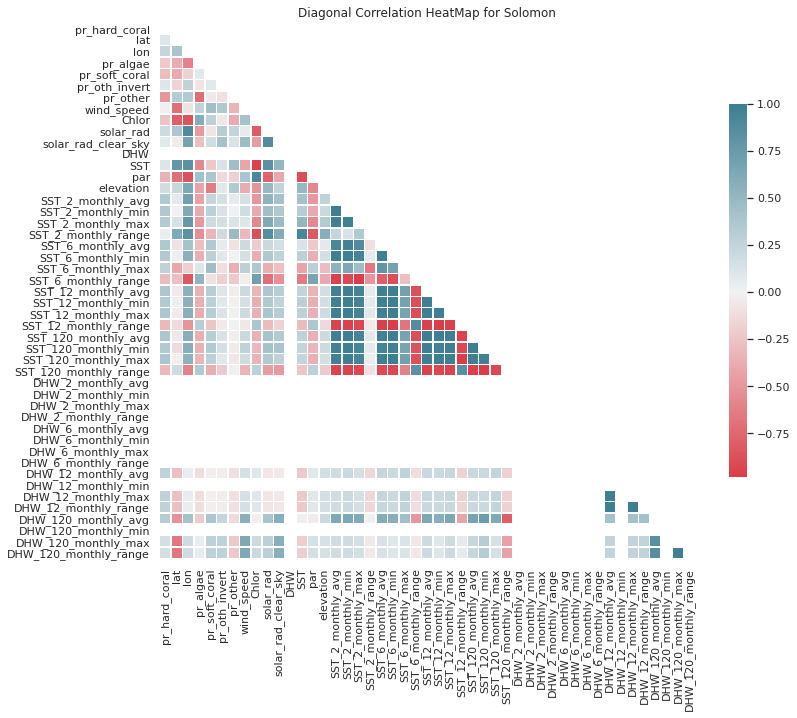

In [85]:
f, ax = plt.subplots(figsize=(12, 12))
corr = df_data_env_extSLB.drop(columns = ['year','country', 'geometry', 'clear_rad_solar_2_monthly_avg',
       'clear_rad_solar_2_monthly_min', 'clear_rad_solar_2_monthly_max',
       'clear_rad_solar_2_monthly_range', 'clear_rad_solar_6_monthly_avg',
       'clear_rad_solar_6_monthly_min', 'clear_rad_solar_6_monthly_max',
       'clear_rad_solar_6_monthly_range', 'clear_rad_solar_12_monthly_avg',
       'clear_rad_solar_12_monthly_min', 'clear_rad_solar_12_monthly_max',
       'clear_rad_solar_12_monthly_range', 'wind_2_monthly_avg',
       'wind_2_monthly_min', 'wind_2_monthly_max', 'wind_2_monthly_range',
       'wind_6_monthly_avg', 'wind_6_monthly_min', 'wind_6_monthly_max',
       'wind_6_monthly_range', 'wind_12_monthly_avg', 'wind_12_monthly_min',
       'wind_12_monthly_max', 'wind_12_monthly_range', 'wind_120_monthly_avg',
       'wind_120_monthly_min', 'wind_120_monthly_max',
       'wind_120_monthly_range', 'solar_2_monthly_avg', 'solar_2_monthly_min',
       'solar_2_monthly_max', 'solar_2_monthly_range', 'solar_6_monthly_avg',
       'solar_6_monthly_min', 'solar_6_monthly_max', 'solar_6_monthly_range',
       'solar_12_monthly_avg', 'solar_12_monthly_min', 'solar_12_monthly_max',
       'solar_12_monthly_range']).corr()
keep_interesting_corr(corr,df_keep_env_ext, "SLB (20)") 
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for Solomon")

**Take-aways**
Hard corals:
- Negative corr with PAR (normal)


Text(0.5, 1.0, 'Diagonal Correlation HeatMap for Timor Leste')

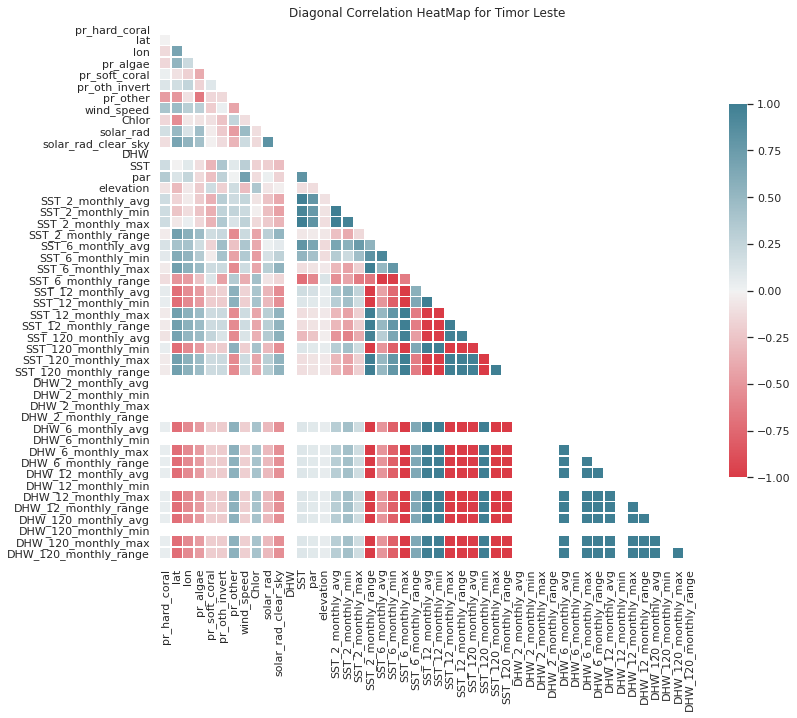

In [86]:
f, ax = plt.subplots(figsize=(12, 12))
corr = df_data_env_extTLS.drop(columns = ['year','country', 'geometry', 'clear_rad_solar_2_monthly_avg',
       'clear_rad_solar_2_monthly_min', 'clear_rad_solar_2_monthly_max',
       'clear_rad_solar_2_monthly_range', 'clear_rad_solar_6_monthly_avg',
       'clear_rad_solar_6_monthly_min', 'clear_rad_solar_6_monthly_max',
       'clear_rad_solar_6_monthly_range', 'clear_rad_solar_12_monthly_avg',
       'clear_rad_solar_12_monthly_min', 'clear_rad_solar_12_monthly_max',
       'clear_rad_solar_12_monthly_range', 'wind_2_monthly_avg',
       'wind_2_monthly_min', 'wind_2_monthly_max', 'wind_2_monthly_range',
       'wind_6_monthly_avg', 'wind_6_monthly_min', 'wind_6_monthly_max',
       'wind_6_monthly_range', 'wind_12_monthly_avg', 'wind_12_monthly_min',
       'wind_12_monthly_max', 'wind_12_monthly_range', 'wind_120_monthly_avg',
       'wind_120_monthly_min', 'wind_120_monthly_max',
       'wind_120_monthly_range', 'solar_2_monthly_avg', 'solar_2_monthly_min',
       'solar_2_monthly_max', 'solar_2_monthly_range', 'solar_6_monthly_avg',
       'solar_6_monthly_min', 'solar_6_monthly_max', 'solar_6_monthly_range',
       'solar_12_monthly_avg', 'solar_12_monthly_min', 'solar_12_monthly_max',
       'solar_12_monthly_range']).corr()
keep_interesting_corr(corr,df_keep_env_ext, "TLS (26)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for Timor Leste")

**Take-aways**

Hard corals have:
- Positive corr with wind speed (normal)
- Positive corr with PAR (strange)

Text(0.5, 1.0, 'Diagonal Correlation HeatMap for Australia')

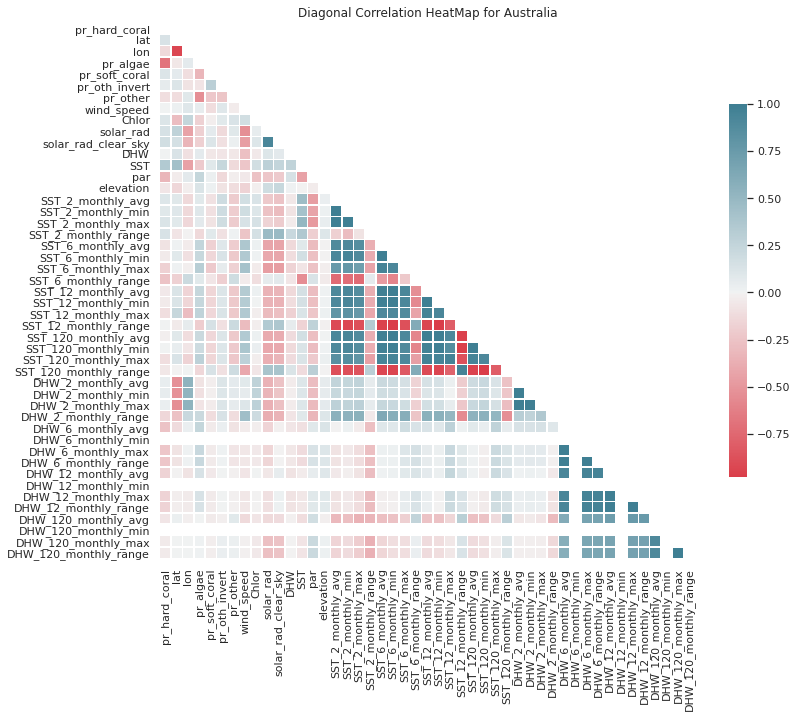

In [87]:
f, ax = plt.subplots(figsize=(12, 12))
corr = df_data_env_extAUS.drop(columns = ['year','country', 'geometry', 'clear_rad_solar_2_monthly_avg',
       'clear_rad_solar_2_monthly_min', 'clear_rad_solar_2_monthly_max',
       'clear_rad_solar_2_monthly_range', 'clear_rad_solar_6_monthly_avg',
       'clear_rad_solar_6_monthly_min', 'clear_rad_solar_6_monthly_max',
       'clear_rad_solar_6_monthly_range', 'clear_rad_solar_12_monthly_avg',
       'clear_rad_solar_12_monthly_min', 'clear_rad_solar_12_monthly_max',
       'clear_rad_solar_12_monthly_range', 'wind_2_monthly_avg',
       'wind_2_monthly_min', 'wind_2_monthly_max', 'wind_2_monthly_range',
       'wind_6_monthly_avg', 'wind_6_monthly_min', 'wind_6_monthly_max',
       'wind_6_monthly_range', 'wind_12_monthly_avg', 'wind_12_monthly_min',
       'wind_12_monthly_max', 'wind_12_monthly_range', 'wind_120_monthly_avg',
       'wind_120_monthly_min', 'wind_120_monthly_max',
       'wind_120_monthly_range', 'solar_2_monthly_avg', 'solar_2_monthly_min',
       'solar_2_monthly_max', 'solar_2_monthly_range', 'solar_6_monthly_avg',
       'solar_6_monthly_min', 'solar_6_monthly_max', 'solar_6_monthly_range',
       'solar_12_monthly_avg', 'solar_12_monthly_min', 'solar_12_monthly_max',
       'solar_12_monthly_range']).corr()
keep_interesting_corr(corr,df_keep_env_ext, "AUS (260)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for Australia")

**Take-aways**

Hard corals:
- Positive corr with SST (strange)
- Negative corr with PAR (normal)

Text(0.5, 1.0, 'Diagonal Correlation HeatMap for Indonesia')

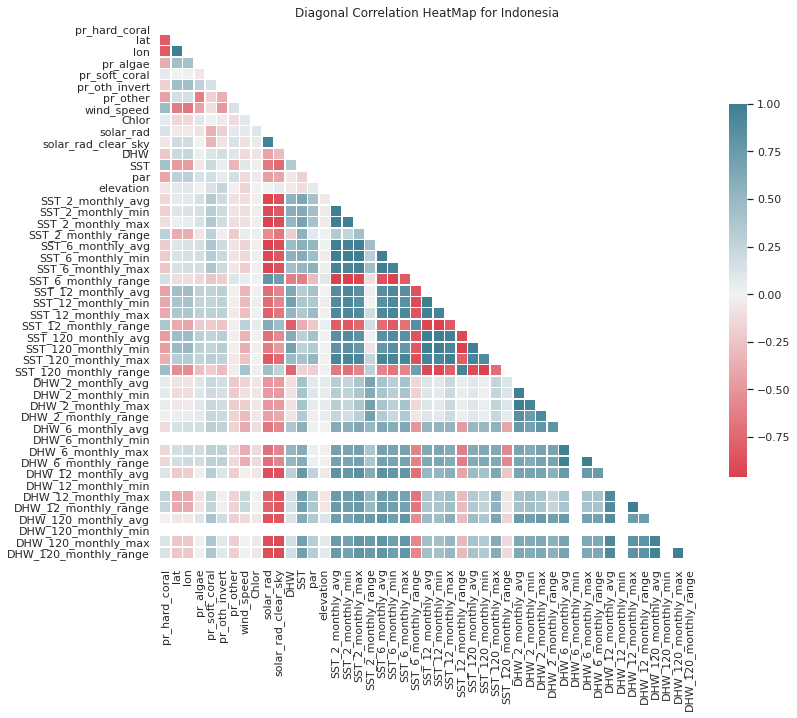

In [88]:
f, ax = plt.subplots(figsize=(12, 12))

corr = df_data_env_extIDN.drop(columns = ['year','country', 'geometry', 'clear_rad_solar_2_monthly_avg',
       'clear_rad_solar_2_monthly_min', 'clear_rad_solar_2_monthly_max',
       'clear_rad_solar_2_monthly_range', 'clear_rad_solar_6_monthly_avg',
       'clear_rad_solar_6_monthly_min', 'clear_rad_solar_6_monthly_max',
       'clear_rad_solar_6_monthly_range', 'clear_rad_solar_12_monthly_avg',
       'clear_rad_solar_12_monthly_min', 'clear_rad_solar_12_monthly_max',
       'clear_rad_solar_12_monthly_range', 'wind_2_monthly_avg',
       'wind_2_monthly_min', 'wind_2_monthly_max', 'wind_2_monthly_range',
       'wind_6_monthly_avg', 'wind_6_monthly_min', 'wind_6_monthly_max',
       'wind_6_monthly_range', 'wind_12_monthly_avg', 'wind_12_monthly_min',
       'wind_12_monthly_max', 'wind_12_monthly_range', 'wind_120_monthly_avg',
       'wind_120_monthly_min', 'wind_120_monthly_max',
       'wind_120_monthly_range', 'solar_2_monthly_avg', 'solar_2_monthly_min',
       'solar_2_monthly_max', 'solar_2_monthly_range', 'solar_6_monthly_avg',
       'solar_6_monthly_min', 'solar_6_monthly_max', 'solar_6_monthly_range',
       'solar_12_monthly_avg', 'solar_12_monthly_min', 'solar_12_monthly_max',
       'solar_12_monthly_range']).corr()

keep_interesting_corr(corr,df_keep_env_ext, "IDN (110)") 
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for Indonesia")

**Take-aways**

Hard corals have:
- Positive corr with wind speed

In [89]:
frame_corr_env_ext = pd.concat(df_keep_env_ext, axis = 1)

In [90]:
classes = frame_corr_env_ext.columns

In [91]:
strs = ["pr_hard" for x in range(len(frame_corr_env_ext.columns))]

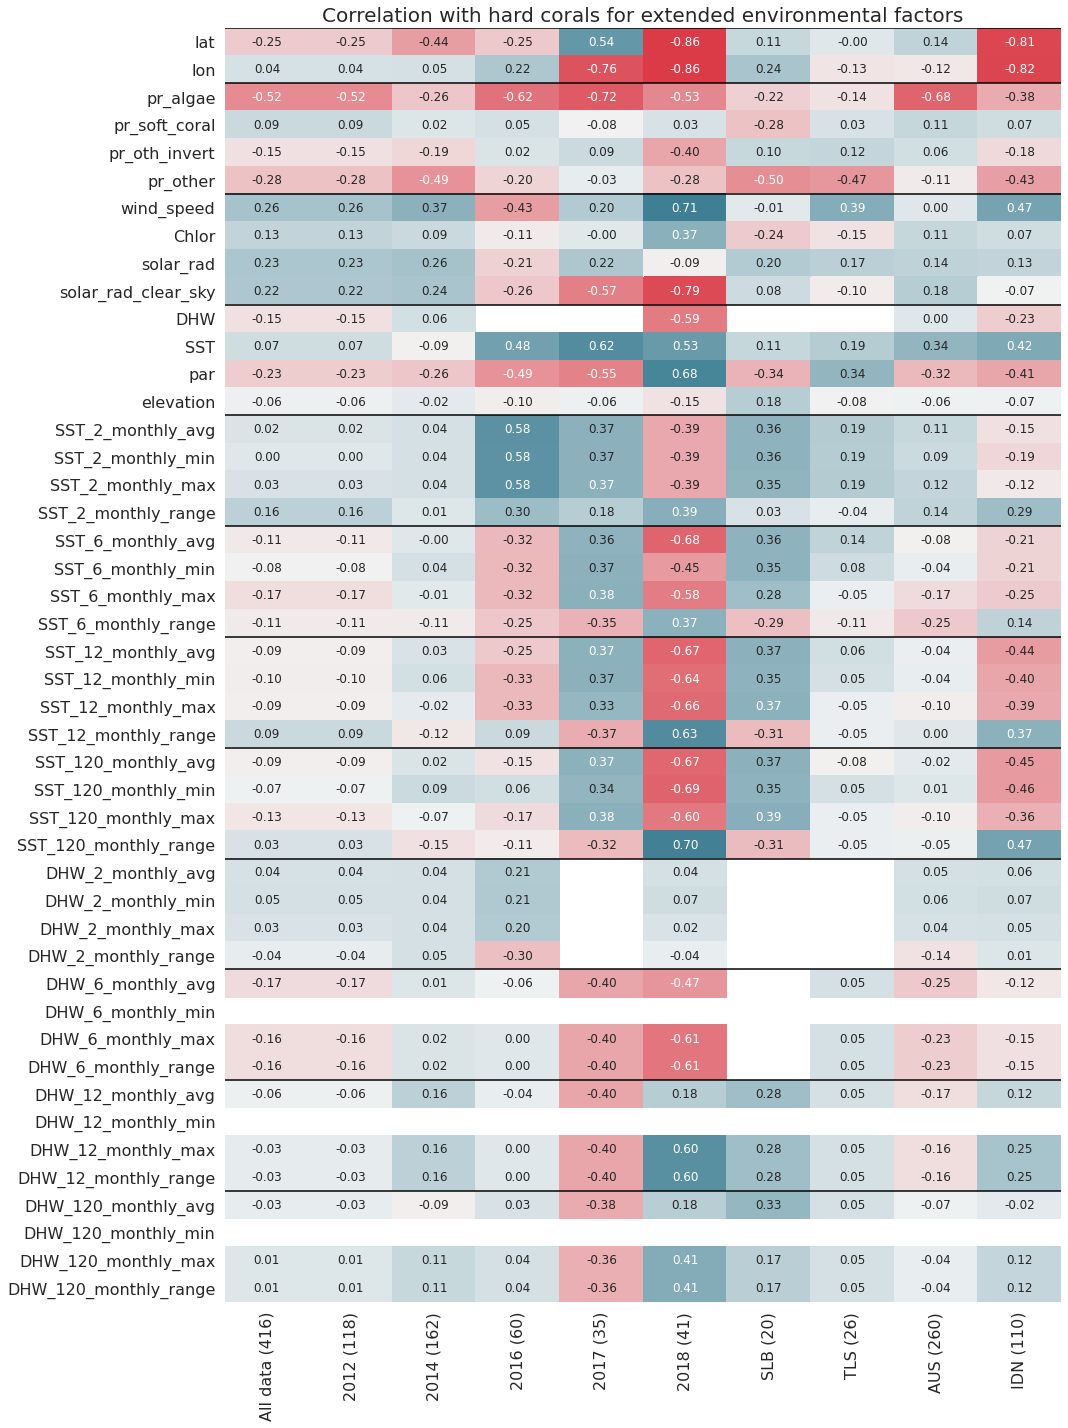

In [97]:
plt.figure(figsize=(15,20))
yticks = frame_corr_env_ext.index
ok_len = len(frame_corr_env_ext.index)
keptticks = yticks[::int(len(yticks)/ok_len)]
yticks = ['' for y in yticks]
yticks[::int(len(yticks)/ok_len)] = keptticks

xticks = frame_corr_env.columns
#xticks = strs
keptticks = xticks[::int(len(xticks)/10)]
xticks = ['' for y in xticks]
xticks[::int(len(xticks)/10)] = keptticks
cmap = sns.diverging_palette(10, 220, as_cmap=True)

ax = sns.heatmap(frame_corr_env_ext,cmap = cmap, linewidth=0,yticklabels=yticks,xticklabels=xticks,annot=True, cbar = False ,fmt='.2f')
ax.hlines([0,2, 6, 10, 14,18, 22, 26, 30, 34,38, 42], colors = "black",*ax.get_xlim())

# This sets the yticks "upright" with 0, as opposed to sideways with 90.
plt.yticks(rotation=0,fontsize = 16) 
plt.xticks(rotation=90,fontsize = 16) 
plt.title("Correlation with hard corals for extended environmental factors",fontsize = 20)
plt.tight_layout()
plt.show()

